In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Importation of the data

In [2]:
final_table_df = pd.read_csv("def_table_final.txt", sep='\t+', lineterminator='\n')
final_table_df

/tmp/ipykernel_16741/156718932.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  final_table_df = pd.read_csv("def_table_final.txt", sep='\t+', lineterminator='\n')


,individual,id,transcript_id,name,chromosome_number,sequence
0,SNP_merged_HG00097.selgene_snps.unique.txt,ENSP00000368166,ENST00000378888,DVL1-004,1,MAETKIIYHMDEEETPYLVKLPLAPERVTLADFKNVLSNRPVHAYK...
1,SNP_merged_HG00097.selgene_snps.unique.txt,ENSP00000368169,ENST00000378891,DVL1-001,1,MAETKIIYHMDEEETPYLVKLPLAPERVTLADFKNVLSNRPVHAYK...
2,SNP_merged_HG00097.selgene_snps.unique.txt,ENSP00000311537,ENST00000307896,THAP3-003,1,MPK*CAARQCCNRYSSRRKQLTFHRFPFSRPQLLKEWVLNIGRGNF...
3,SNP_merged_HG00097.selgene_snps.unique.txt,ENSP00000054650,ENST00000054650,THAP3-001,1,MPK*CAARQCCNRYSSRRKQLTFHRFPFSRPQLLKEWVLNIGRGNF...
4,SNP_merged_HG00097.selgene_snps.unique.txt,ENSP00000473646,ENST00000472925,THAP3-005,1,CAARQCCNRYSSRRKQLTFHRFPFSRPQLLKEWVLNIGRGNFKPKQ...
...,...,...,...,...,...,...
994855,SNP_merged_NA20539.selgene_snps.unique.txt,ENSP00000291670,ENST00000291670,FTCD-004,21,MSQLVECVPNFLEGKNQEVIDAISGAITQTLCCVLLDVDAGPSTNH...
994856,SNP_merged_NA20539.selgene_snps.unique.txt,ENSP00000348762,ENST00000356396,LSS-002,21,MTEGTCLRRRGGPYKTEPATDLGRWRLNCDKGRQTWTYLQDERAGR...
994857,SNP_merged_NA20539.selgene_snps.unique.txt,ENSP00000429133,ENST00000522411,LSS-010,21,MTEGTCLRRRGGPYKTEPATDLGRWRLNCDKGRQTWTYLQDERAGR...
994858,SNP_merged_NA20539.selgene_snps.unique.txt,ENSP00000380837,ENST00000397728,LSS-001,21,none


# Cleaning data

The asterisks present in the sequences represent the stop codons, therefore each time one is encountered, the sequence is truncated at that point. The slashes, instead, represent the possible alternatives of a certain amino acid. In this case, all the alternatives and the reference have been deleted from the sequence and, therefore, not taken into account in the calculation of the amino acid frequency.

In [3]:
sequece_sum = {}
for index, row in tqdm(final_table_df.iterrows(), total=final_table_df.shape[0]):
    individual = row["individual"]
    id = row["id"]
    transcript_id = row["transcript_id"]
    name = row["name"]
    chromosome_number = row["chromosome_number"]
    sequence = row["sequence"]

    individual = individual.split(".")[0].split("_")[-1]

    # Clean sequence
    cleane_sequence = sequence.split("*")[0]
    indices = [i for i, a in enumerate(cleane_sequence) if a == "/"]
    set_indices = set([])
    for i in indices:
        set_indices.update([i-1])
        set_indices.update([i])
        set_indices.update([i+1])
    cleane_sequence = "".join([char for idx, char in enumerate(cleane_sequence) if idx not in set_indices])

    if cleane_sequence == "none":
        continue

    if individual not in sequece_sum:
        sequece_sum[individual] = cleane_sequence
    else:
        sequece_sum[individual] += cleane_sequence

100%|██████████| 994860/994860 [01:54<00:00, 8670.79it/s]


In [4]:
alphabet_dict = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0, "G": 0, "H": 0, "I": 0, "J": 0, "K": 0, "L": 0, "M": 0, "N": 0, "O": 0, "P": 0, "Q": 0, "R": 0, "S": 0, "T": 0, "U": 0, "V": 0, "W": 0, "X": 0, "Y": 0, "Z": 0}
freq_dict = {}

for individual in sequece_sum:

    sequence = sequece_sum[individual]

    for elem in alphabet_dict:
        if len(sequence) == 0:
            alphabet_dict[elem] = 0 
        else:    
            alphabet_dict[elem] = sequence.count(elem) / len(sequence)
        
    freq_dict[individual] = alphabet_dict.copy()

    alphabet_dict = {"A": 0, "B": 0, "C": 0, "D": 0, "E": 0, "F": 0, "G": 0, "H": 0, "I": 0, "J": 0, "K": 0, "L": 0, "M": 0, "N": 0, "O": 0, "P": 0, "Q": 0, "R": 0, "S": 0, "T": 0, "U": 0, "V": 0, "W": 0, "X": 0, "Y": 0, "Z": 0}

The amino acid frequency is defined in this case as the number of times the same amino acid appears in all the protein sequences of an individual divided by the length of the sequence.

$f = count(amino acid) / len(sequence)$

In [5]:
freq = pd.DataFrame.from_dict(freq_dict, orient='index')
freq.index.names = ['individual']
freq.reset_index(level=0, inplace=True)
freq = freq.loc[:, (freq != 0.0).any(axis=0)]

# Print of the table of aminoacidic frequencies for each amino acid
freq

,individual,A,C,D,E,F,G,H,I,K,...,N,P,Q,R,S,T,U,V,W,Y
0,HG00097,0.071115,0.020275,0.049337,0.069771,0.036098,0.069685,0.025143,0.045184,0.061353,...,0.035606,0.059900,0.047687,0.054654,0.079180,0.051422,0.000003,0.062655,0.012576,0.027680
1,HG00100,0.071119,0.020274,0.049340,0.069764,0.036095,0.069694,0.025154,0.045187,0.061350,...,0.035602,0.059882,0.047678,0.054657,0.079193,0.051413,0.000003,0.062655,0.012575,0.027678
2,HG00101,0.071106,0.020273,0.049336,0.069769,0.036097,0.069694,0.025151,0.045179,0.061350,...,0.035602,0.059888,0.047676,0.054670,0.079176,0.051420,0.000003,0.062663,0.012578,0.027676
3,HG00105,0.071114,0.020271,0.049341,0.069774,0.036106,0.069693,0.025149,0.045185,0.061353,...,0.035598,0.059885,0.047679,0.054661,0.079187,0.051418,0.000003,0.062667,0.012578,0.027674
4,HG00106,0.071103,0.020261,0.049344,0.069774,0.036096,0.069687,0.025148,0.045187,0.061350,...,0.035599,0.059881,0.047685,0.054655,0.079195,0.051425,0.000003,0.062652,0.012583,0.027676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NA20528,0.071116,0.020271,0.049336,0.069771,0.036094,0.069688,0.025144,0.045186,0.061354,...,0.035596,0.059889,0.047678,0.054665,0.079195,0.051411,0.000003,0.062662,0.012577,0.027679
176,NA20530,0.071105,0.020265,0.049339,0.069771,0.036099,0.069690,0.025151,0.045181,0.061354,...,0.035601,0.059882,0.047680,0.054657,0.079189,0.051420,0.000003,0.062668,0.012578,0.027672
177,NA20534,0.071109,0.020276,0.049340,0.069768,0.036093,0.069691,0.025148,0.045178,0.061360,...,0.035601,0.059884,0.047674,0.054670,0.079193,0.051425,0.000003,0.062670,0.012575,0.027675
178,NA20535,0.071108,0.020266,0.049344,0.069766,0.036098,0.069695,0.025145,0.045184,0.061353,...,0.035593,0.059886,0.047685,0.054657,0.079199,0.051414,0.000003,0.062657,0.012581,0.027678


# Data analysis

## Boxplot

This first boxplot shows an overview that allows to understand more or less where the frequencies are positioned relative to each other. As it is possible to notice, they are very close to each other in a small range of values.

<AxesSubplot:>

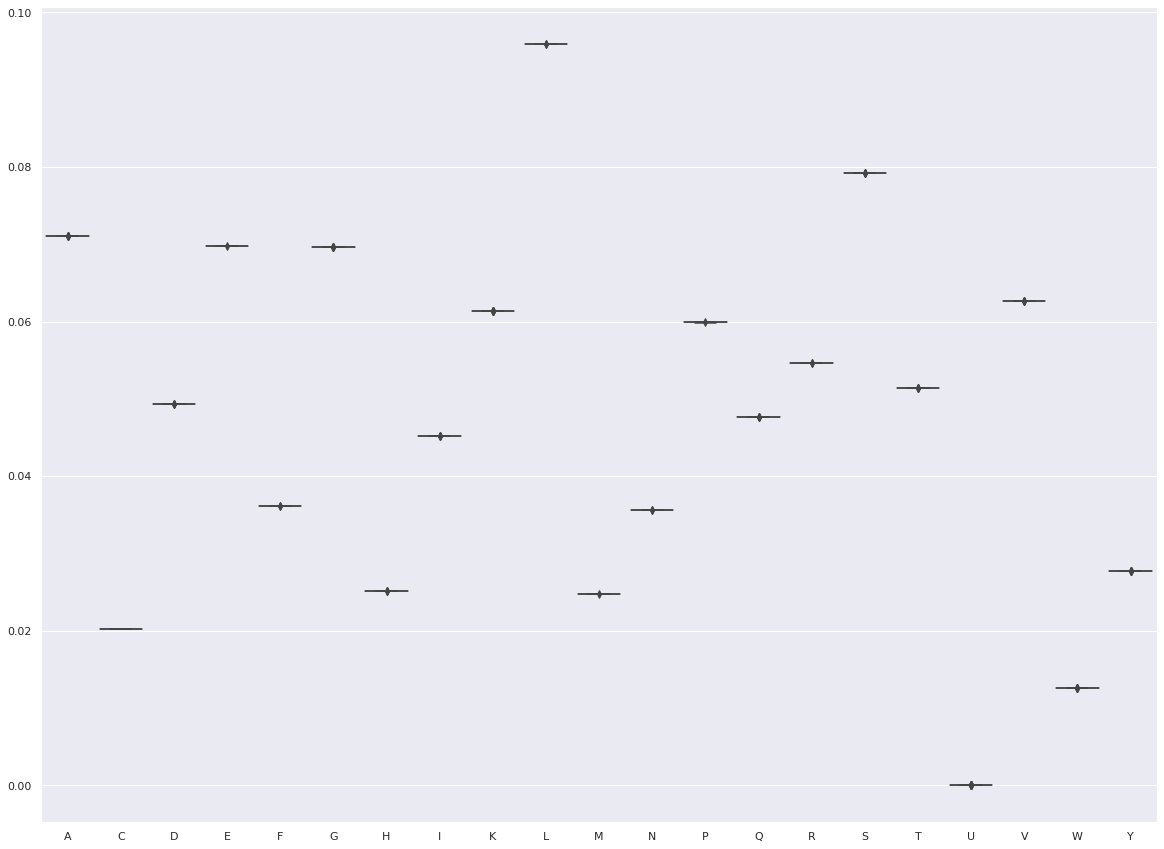

In [8]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(20,15)})
sns.boxplot(data = freq)

## Correlation map

The correlation map shows the relationship between the various variables taken two by two. This provides a further overview on the data and how they are disposed in relation to one another.

<AxesSubplot:>

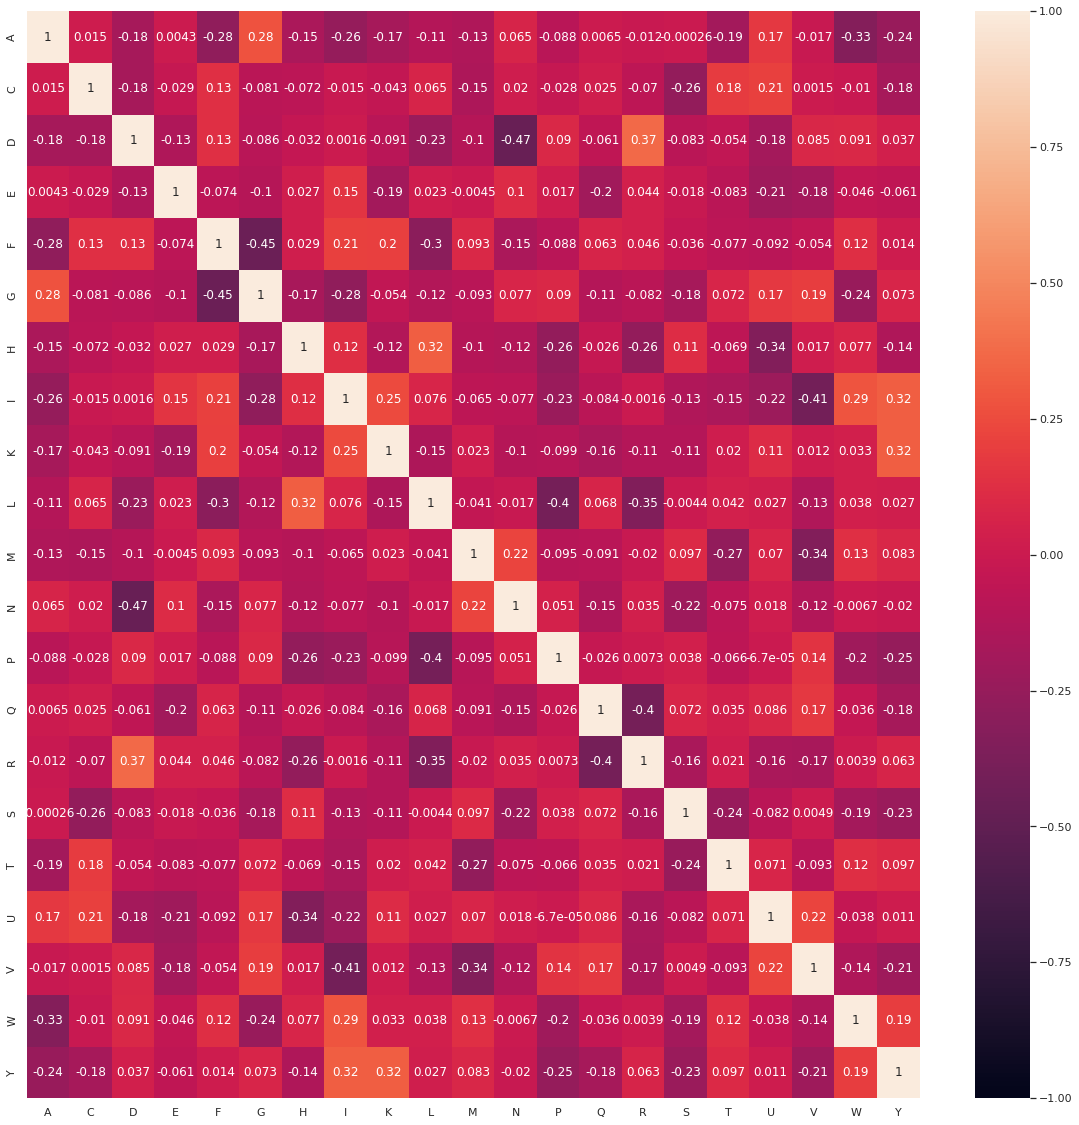

In [9]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(freq.corr(), vmin=-1, vmax=1, annot=True)

## Diet analysis

The analysis of interest includes the division and classification of individuals with respect to the dietary classes to which they belong. Therefore, we import the diet.txt file in which all individuals are assigned a fundamental diet.

In [10]:
# Import the diet file
diet = pd.read_csv('Diet.txt', sep = "\t")
dict_diet = dict(diet.values)

In [11]:
# Check if all individuals are assigned a diet in the file
individual_no_diet = []
for index, row in tqdm(freq.iterrows(), total=freq.shape[0]):
    individual = row["individual"]

    if individual in dict_diet:
        freq.loc[index, 'diet'] = dict_diet[individual]
    else:
        if individual not in individual_no_diet:
            individual_no_diet.append(individual)

individual_no_diet

100%|██████████| 180/180 [00:00<00:00, 7954.97it/s]


[]

In [12]:
# Saving new table of interest
freq.to_csv('freq.csv')

### PCA - Principal Component Analysis

It is a statistical procedure that allows to summarize the information content in large data tables by means of a smaller set of “summary indices” that can be more easily visualized and analyzed. Here a graph is created which, with different colors for different diets, shows the arrangement of the principal components.

In [13]:
# from saved file freq importation
freq = pd.read_csv("freq.csv", index_col = 0).reset_index(drop = True)
freq

,individual,A,C,D,E,F,G,H,I,K,...,P,Q,R,S,T,U,V,W,Y,diet
0,HG00097,0.071115,0.020275,0.049337,0.069771,0.036098,0.069685,0.025143,0.045184,0.061353,...,0.059900,0.047687,0.054654,0.079180,0.051422,0.000003,0.062655,0.012576,0.027680,Cereals
1,HG00100,0.071119,0.020274,0.049340,0.069764,0.036095,0.069694,0.025154,0.045187,0.061350,...,0.059882,0.047678,0.054657,0.079193,0.051413,0.000003,0.062655,0.012575,0.027678,Cereals
2,HG00101,0.071106,0.020273,0.049336,0.069769,0.036097,0.069694,0.025151,0.045179,0.061350,...,0.059888,0.047676,0.054670,0.079176,0.051420,0.000003,0.062663,0.012578,0.027676,Cereals
3,HG00105,0.071114,0.020271,0.049341,0.069774,0.036106,0.069693,0.025149,0.045185,0.061353,...,0.059885,0.047679,0.054661,0.079187,0.051418,0.000003,0.062667,0.012578,0.027674,Cereals
4,HG00106,0.071103,0.020261,0.049344,0.069774,0.036096,0.069687,0.025148,0.045187,0.061350,...,0.059881,0.047685,0.054655,0.079195,0.051425,0.000003,0.062652,0.012583,0.027676,Cereals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NA20528,0.071116,0.020271,0.049336,0.069771,0.036094,0.069688,0.025144,0.045186,0.061354,...,0.059889,0.047678,0.054665,0.079195,0.051411,0.000003,0.062662,0.012577,0.027679,Cereals
176,NA20530,0.071105,0.020265,0.049339,0.069771,0.036099,0.069690,0.025151,0.045181,0.061354,...,0.059882,0.047680,0.054657,0.079189,0.051420,0.000003,0.062668,0.012578,0.027672,Cereals
177,NA20534,0.071109,0.020276,0.049340,0.069768,0.036093,0.069691,0.025148,0.045178,0.061360,...,0.059884,0.047674,0.054670,0.079193,0.051425,0.000003,0.062670,0.012575,0.027675,Cereals
178,NA20535,0.071108,0.020266,0.049344,0.069766,0.036098,0.069695,0.025145,0.045184,0.061353,...,0.059886,0.047685,0.054657,0.079199,0.051414,0.000003,0.062657,0.012581,0.027678,Cereals


In [14]:
labels = []
for index, row in tqdm(freq.iterrows(), total=freq.shape[0]):
    labels.append(row["diet"])

letters_cols = list(freq.columns[1:-1])

# Label to color dict (manual)
label_color_dict = {'Cereals':'r','Fat, meat or milk':'g','Roots and Tubers':'b'}

# Color vector creation
cvec = [label_color_dict[label] for label in labels]

100%|██████████| 180/180 [00:00<00:00, 23496.77it/s]


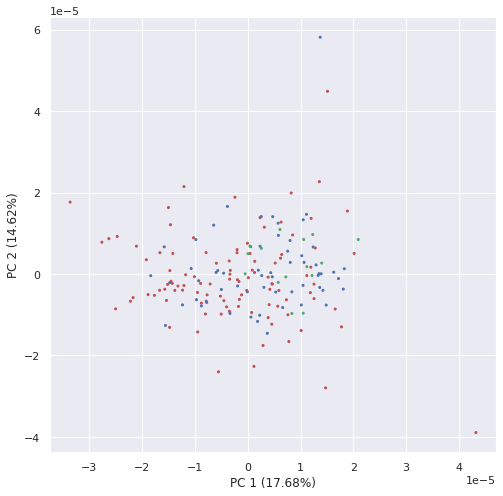

In [15]:
#PCA 
pca = decomposition.PCA(n_components=2)
pca.fit(freq[letters_cols])
features_pca = pca.transform(freq[letters_cols])


# Create the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(features_pca[:,0], features_pca[:,1],
            c=cvec, s=4)

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

plt.show()

### Barplot

In this barplot the amino acid frequencies are arranged according to the diet. As it is possible to notice, at first glance there are no particular differences.

<AxesSubplot:xlabel='diet'>

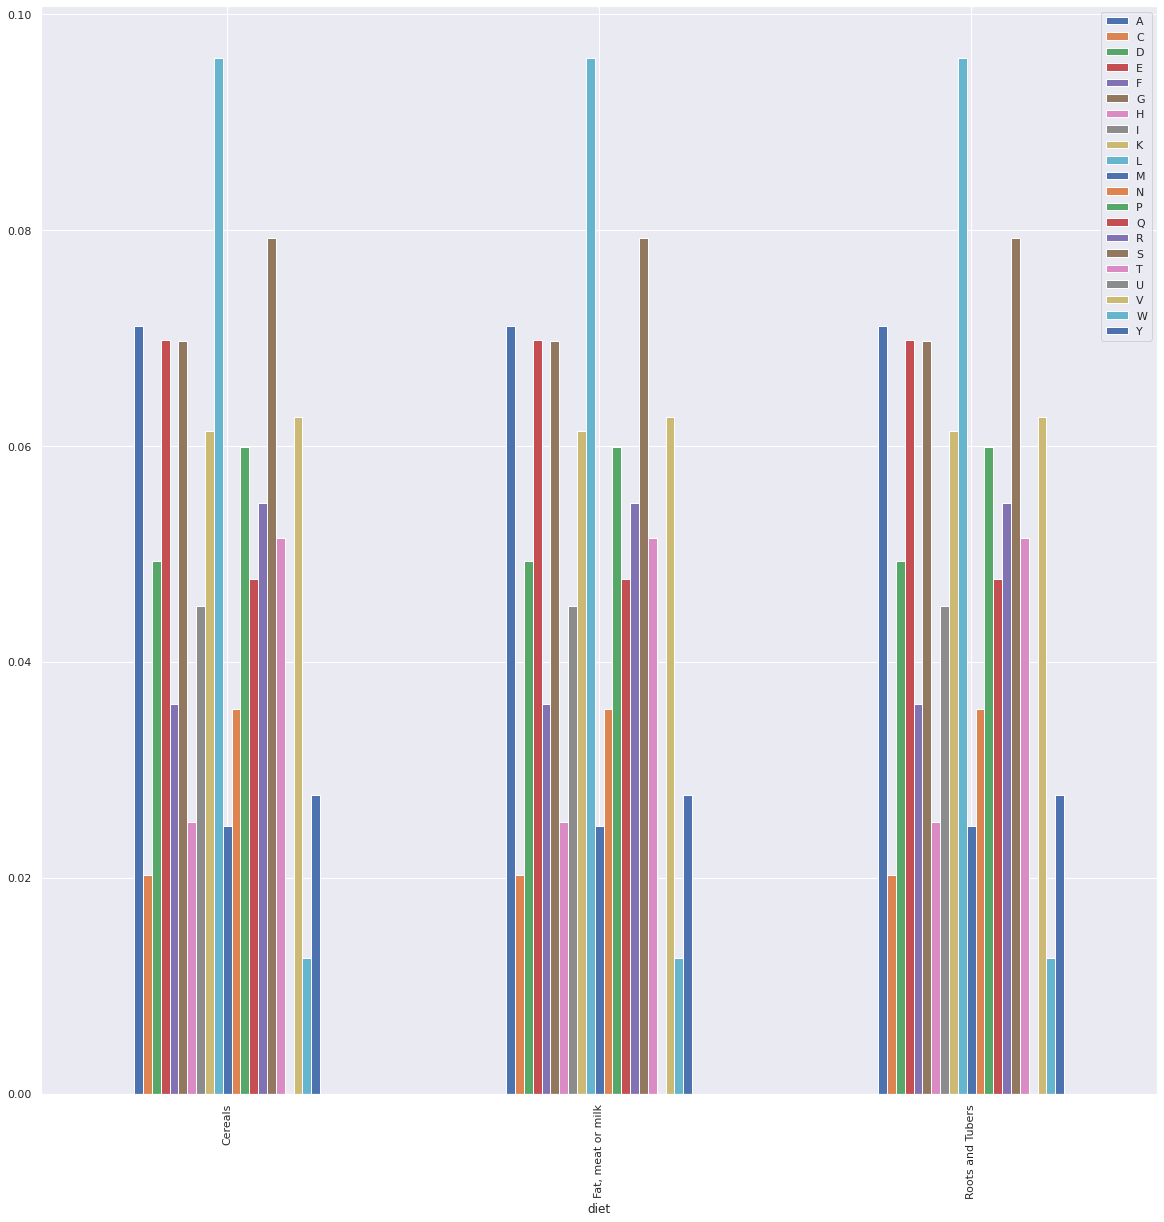

In [16]:
freq.groupby(['diet']).mean().plot(kind = "bar")

Since no particular difference can be appreciated from the barplot above, the analysis was focused on the differences between the overall medians of the amino acid frequency in each diet group.
A plot is shown below to facilitate the interpretation. 

In [17]:
# Table of the median values
freq.groupby(['diet']).median()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,U,V,W,Y
diet,,,,,,,,,,,,,,,,,,,,,
Cereals,0.071107,0.020270,0.049342,0.069769,0.036099,0.069690,0.025149,0.045182,0.061352,0.095889,...,0.035597,0.059889,0.047683,0.054662,0.079195,0.051418,0.000003,0.062663,0.012577,0.027676
"Fat, meat or milk",0.071101,0.020272,0.049341,0.069771,0.036104,0.069687,0.025154,0.045183,0.061350,0.095893,...,0.035596,0.059882,0.047682,0.054660,0.079196,0.051416,0.000003,0.062661,0.012578,0.027677
Roots and Tubers,0.071104,0.020270,0.049342,0.069769,0.036099,0.069689,0.025153,0.045182,0.061353,0.095893,...,0.035596,0.059886,0.047682,0.054657,0.079195,0.051419,0.000003,0.062662,0.012578,0.027677


In [18]:
cols = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
cereals = freq.loc[freq['diet'] == "Cereals"].groupby(['diet']).median().to_numpy()[0]
fat = freq.loc[freq['diet'] == "Fat, meat or milk"].groupby(['diet']).median().to_numpy()[0]
roots = freq.loc[freq['diet'] == "Roots and Tubers"].groupby(['diet']).median().to_numpy()[0]

Since the focus was on "zooming in" the bare differences, the graph reports the absolute values.

In [19]:
cereals_fat = abs(cereals - fat)
cereals_roots = abs(cereals - roots)
fat_roots = abs(fat - roots)

<BarContainer object of 21 artists>

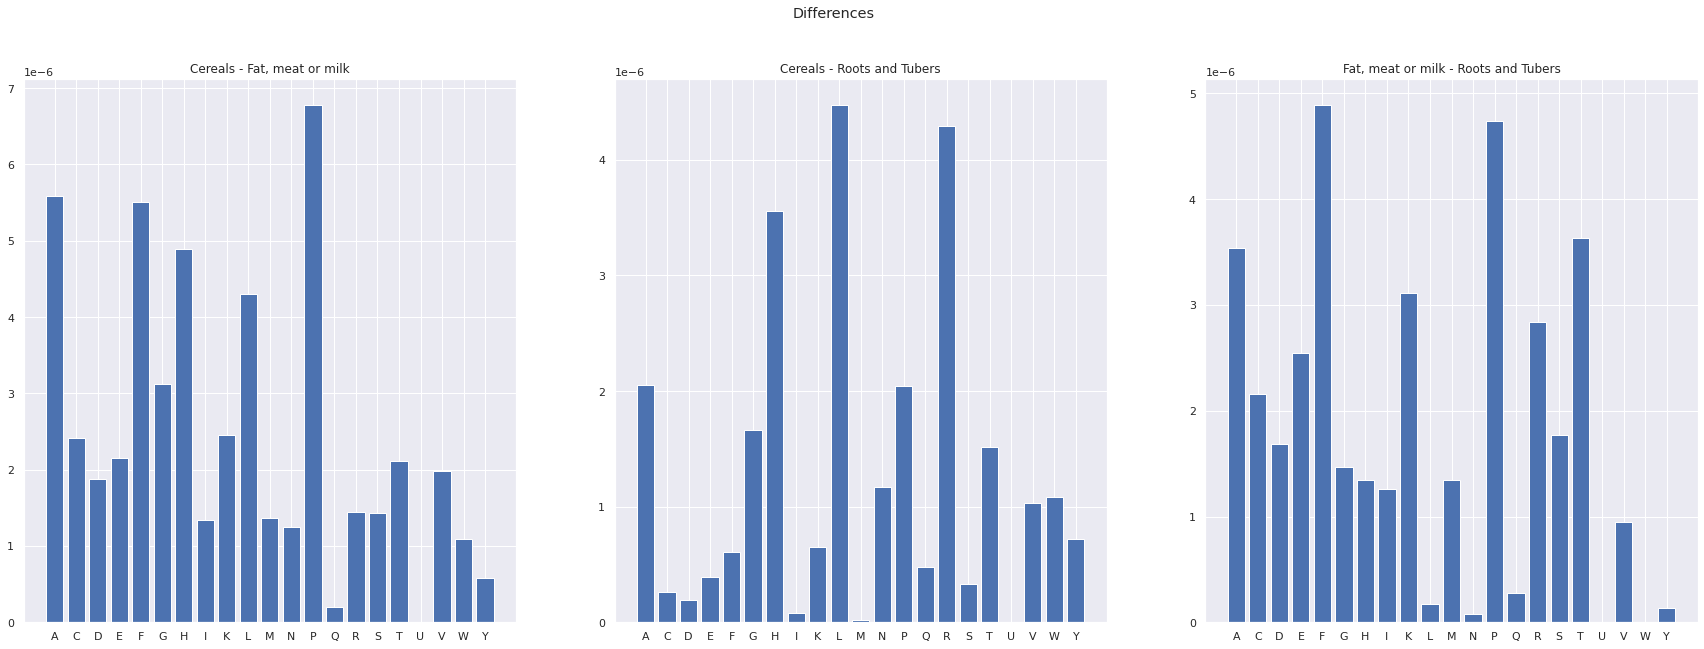

In [20]:
x = cols

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Differences')

ax1.set_title('Cereals - Fat, meat or milk')
ax1.bar(x, cereals_fat)

ax2.set_title('Cereals - Roots and Tubers')
ax2.bar(x, cereals_roots)

ax3.set_title('Fat, meat or milk - Roots and Tubers')
ax3.bar(x, fat_roots)

## CLR - Center Log Ratio 

It is a transformation that can be applied to compositional data. Below all previous measurements are repeated with the clr transformed data.

In [21]:
from skbio.stats.composition import clr

In [22]:
# Center Log Ratio transformation

transformed_freq = {}

for amminoacid in letters_cols:
    mod = clr(freq[[amminoacid]].to_numpy().reshape(180))
    transformed_freq[amminoacid] = mod

new_freq = freq[["individual", "diet"]]

temp_freq = pd.DataFrame.from_dict(transformed_freq)

new_freq = new_freq.join(temp_freq)

In [23]:
# Amino acidic frequency table with clr tranformed data
new_freq

,individual,diet,A,C,D,E,F,G,H,I,...,N,P,Q,R,S,T,U,V,W,Y
0,HG00097,Cereals,0.000160,0.000239,-0.000100,3.193619e-05,-0.000046,-0.000070,-0.000320,0.000029,...,0.000261,2.013391e-04,0.000095,-0.000104,-0.000182,0.000059,-0.000013,-0.000120,-0.000089,0.000148
1,HG00100,Cereals,0.000218,0.000207,-0.000033,-7.400993e-05,-0.000147,0.000060,0.000118,0.000099,...,0.000138,-9.606462e-05,-0.000108,-0.000053,-0.000017,-0.000113,0.000025,-0.000128,-0.000222,0.000082
2,HG00101,Cereals,0.000028,0.000147,-0.000109,-8.251689e-07,-0.000076,0.000062,0.000015,-0.000080,...,0.000149,-7.167788e-07,-0.000142,0.000195,-0.000232,0.000024,0.000037,0.000010,0.000017,-0.000010
3,HG00105,Cereals,0.000138,0.000040,-0.000009,6.972409e-05,0.000162,0.000050,-0.000072,0.000045,...,0.000027,-5.007547e-05,-0.000083,0.000023,-0.000097,-0.000019,0.000035,0.000077,0.000016,-0.000063
4,HG00106,Cereals,-0.000012,-0.000419,0.000051,7.115908e-05,-0.000095,-0.000041,-0.000099,0.000094,...,0.000048,-1.085483e-04,0.000054,-0.000081,0.000004,0.000122,0.000037,-0.000162,0.000416,-0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NA20528,Cereals,0.000170,0.000042,-0.000108,3.074335e-05,-0.000174,-0.000020,-0.000269,0.000079,...,-0.000011,1.198128e-05,-0.000096,0.000104,0.000004,-0.000156,0.000038,-0.000001,-0.000039,0.000094
176,NA20530,Cereals,0.000010,-0.000240,-0.000049,2.189477e-05,-0.000014,0.000012,0.000017,-0.000031,...,0.000131,-9.441400e-05,-0.000064,-0.000052,-0.000076,0.000027,0.000039,0.000080,0.000019,-0.000163
177,NA20534,Cereals,0.000075,0.000301,-0.000031,-2.450222e-05,-0.000179,0.000017,-0.000094,-0.000104,...,0.000105,-7.231754e-05,-0.000180,0.000184,-0.000020,0.000126,0.000013,0.000112,-0.000235,-0.000034
178,NA20535,Cereals,0.000058,-0.000171,0.000051,-5.224566e-05,-0.000056,0.000072,-0.000213,0.000031,...,-0.000093,-3.665934e-05,0.000039,-0.000042,0.000058,-0.000101,0.000037,-0.000082,0.000245,0.000068


### PCA with clr

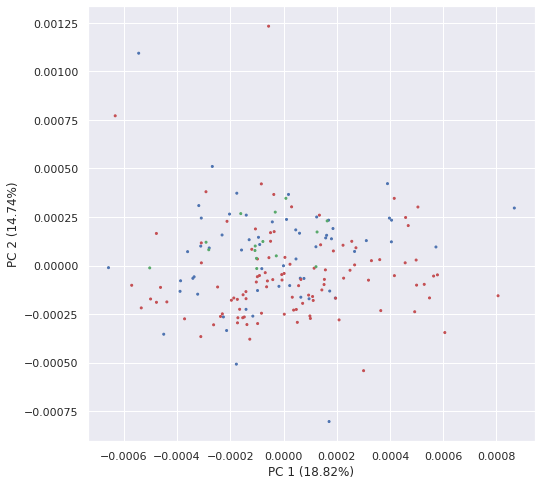

In [24]:
#PCA 
pca = decomposition.PCA(n_components=2)
pca.fit(new_freq[letters_cols])
features_pca = pca.transform(new_freq[letters_cols])


# Create the scatter plot
plt.figure(figsize=(8,8))
plt.scatter(features_pca[:,0], features_pca[:,1],
            c=cvec, s=4)

# Add the axis labels
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

plt.show()

### Barplot with clr

<AxesSubplot:xlabel='diet'>

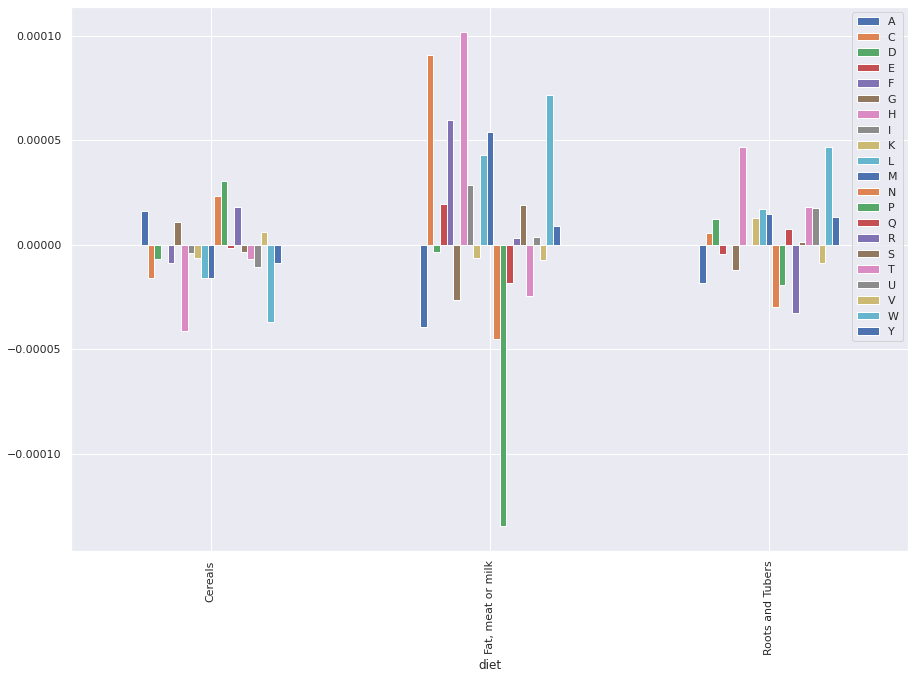

In [25]:
new_freq.groupby(['diet']).mean().plot(kind = "bar", figsize = (15, 10), grid = True)

In [26]:
new_freq.groupby(['diet']).median()

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,U,V,W,Y
diet,,,,,,,,,,,,,,,,,,,,,
Cereals,0.000037,-0.000006,0.000014,-8.251689e-07,-0.000036,0.000012,-0.000069,-0.000018,0.000002,-0.000012,...,0.000009,0.000010,-0.000003,0.000036,3.664656e-06,-0.000017,0.000024,0.000010,-0.000011,-0.000010
"Fat, meat or milk",-0.000042,0.000113,-0.000024,3.002412e-05,0.000117,-0.000033,0.000126,0.000011,-0.000038,0.000033,...,-0.000026,-0.000103,-0.000008,0.000010,2.178421e-05,-0.000059,0.000008,-0.000022,0.000075,0.000011
Roots and Tubers,0.000008,0.000007,0.000010,-6.445935e-06,-0.000019,-0.000011,0.000072,-0.000016,0.000012,0.000034,...,-0.000024,-0.000024,-0.000013,-0.000042,-5.491408e-07,0.000012,0.000037,-0.000007,0.000075,0.000016


In [27]:
cols = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']
new_cereals = new_freq.loc[new_freq['diet'] == "Cereals"].groupby(['diet']).median().to_numpy()[0]
new_fat = new_freq.loc[new_freq['diet'] == "Fat, meat or milk"].groupby(['diet']).median().to_numpy()[0]
new_roots = new_freq.loc[new_freq['diet'] == "Roots and Tubers"].groupby(['diet']).median().to_numpy()[0]

In [28]:
new_cereals_fat = abs(new_cereals - new_fat)
new_cereals_roots = abs(new_cereals - new_roots)
new_fat_roots = abs(new_fat - new_roots)

<BarContainer object of 21 artists>

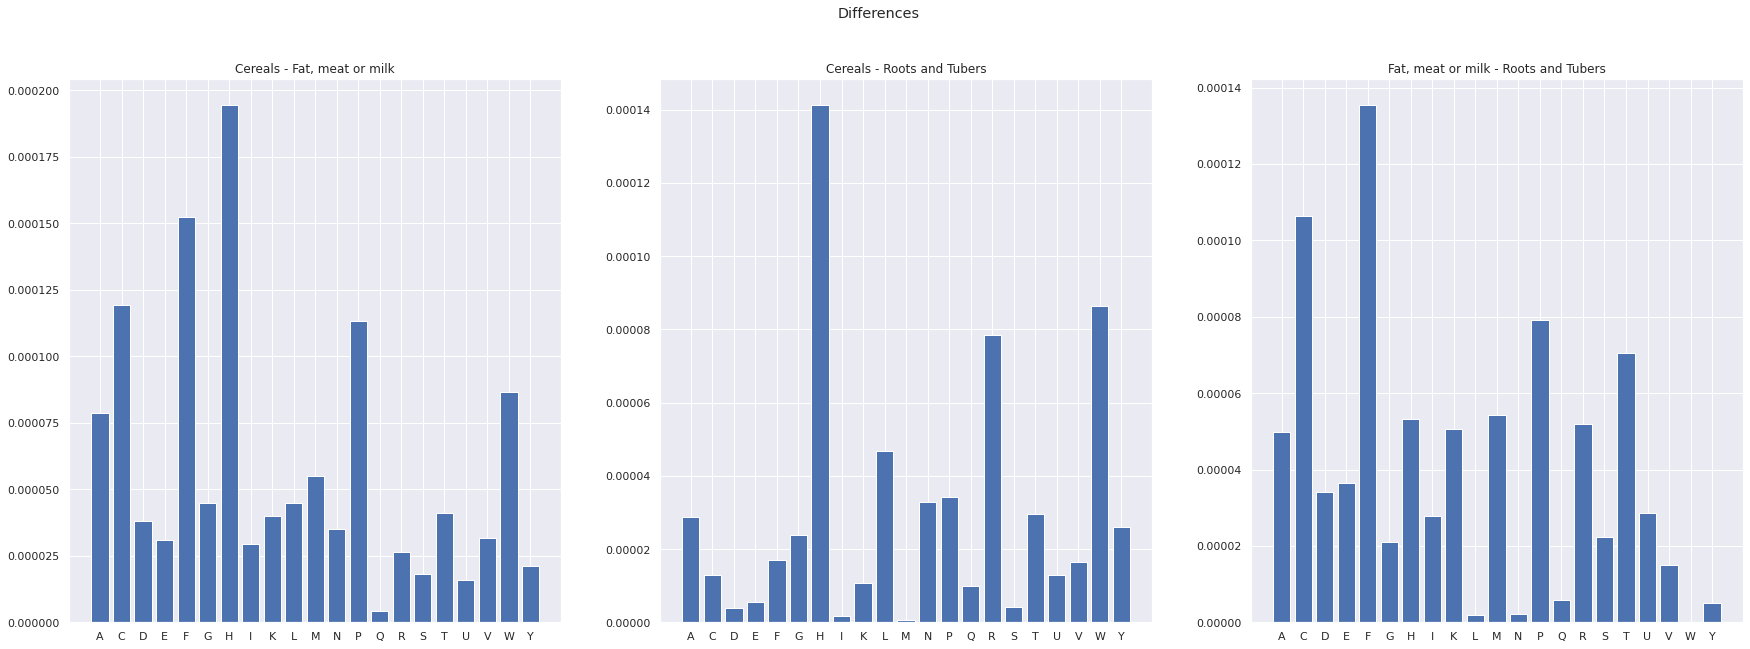

In [29]:
x = cols

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
fig.suptitle('Differences')

ax1.set_title('Cereals - Fat, meat or milk')
ax1.bar(x, new_cereals_fat)

ax2.set_title('Cereals - Roots and Tubers')
ax2.bar(x, new_cereals_roots)

ax3.set_title('Fat, meat or milk - Roots and Tubers')
ax3.bar(x, new_fat_roots)

### Boxplot with clr

To further highlight the subtle differences between the amino acid frequencies of the various diets, the boxplots relating to the individual amino acids are shown below, which are also saved in the Boxplot_clr folder.

/home/silviu/Emma/emmalapiusexydelmondo/venv/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


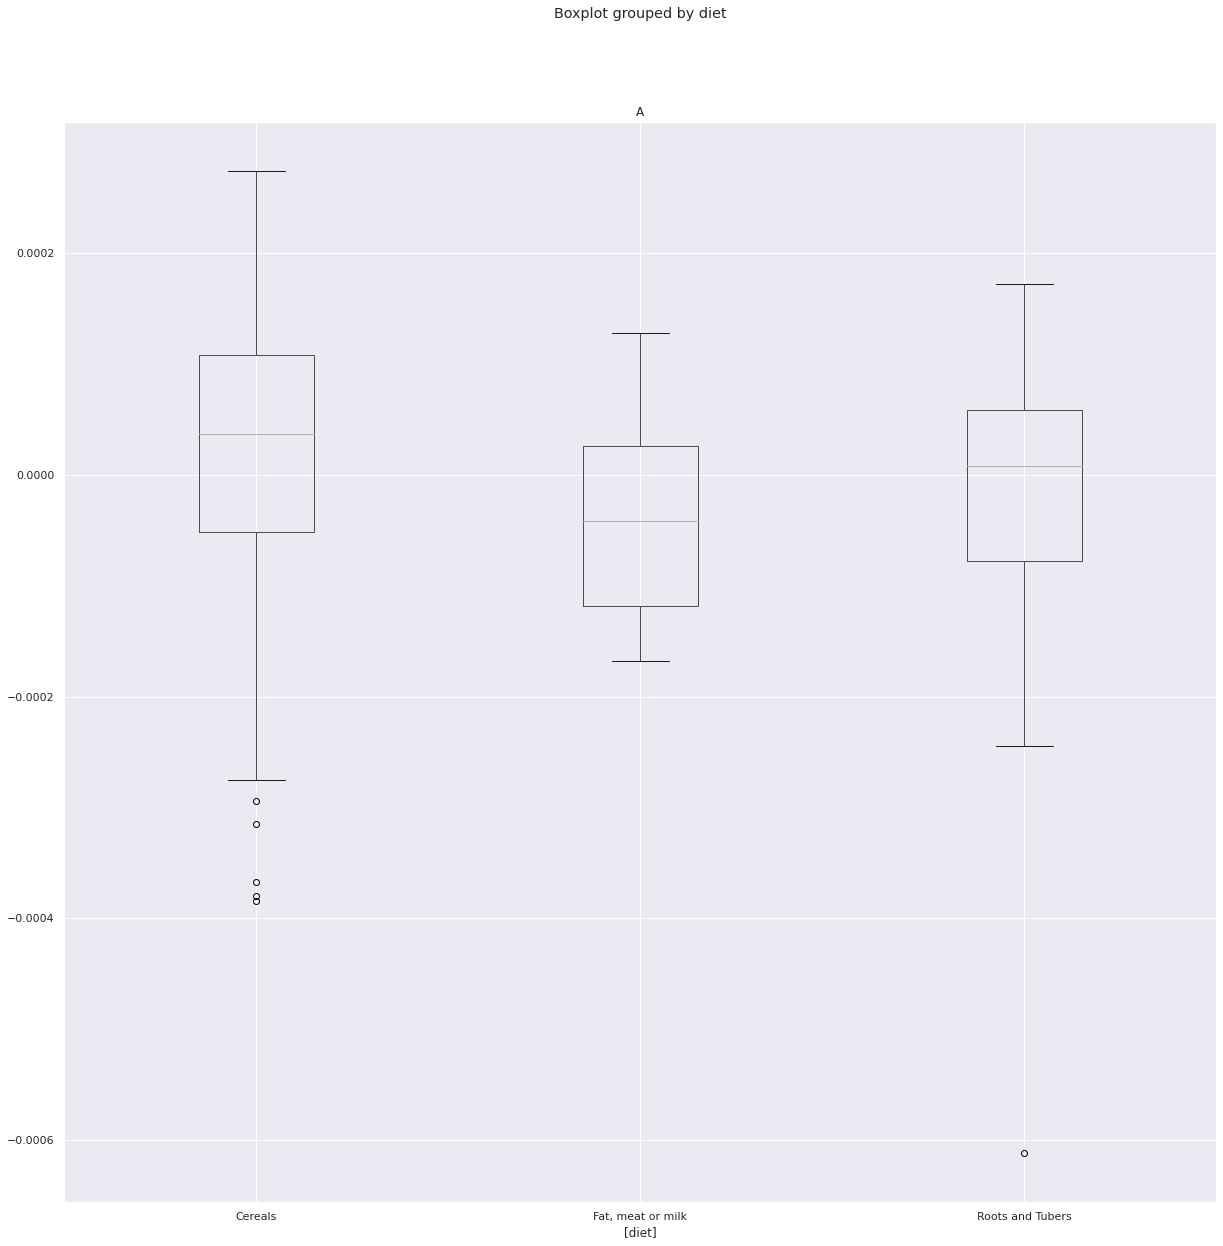

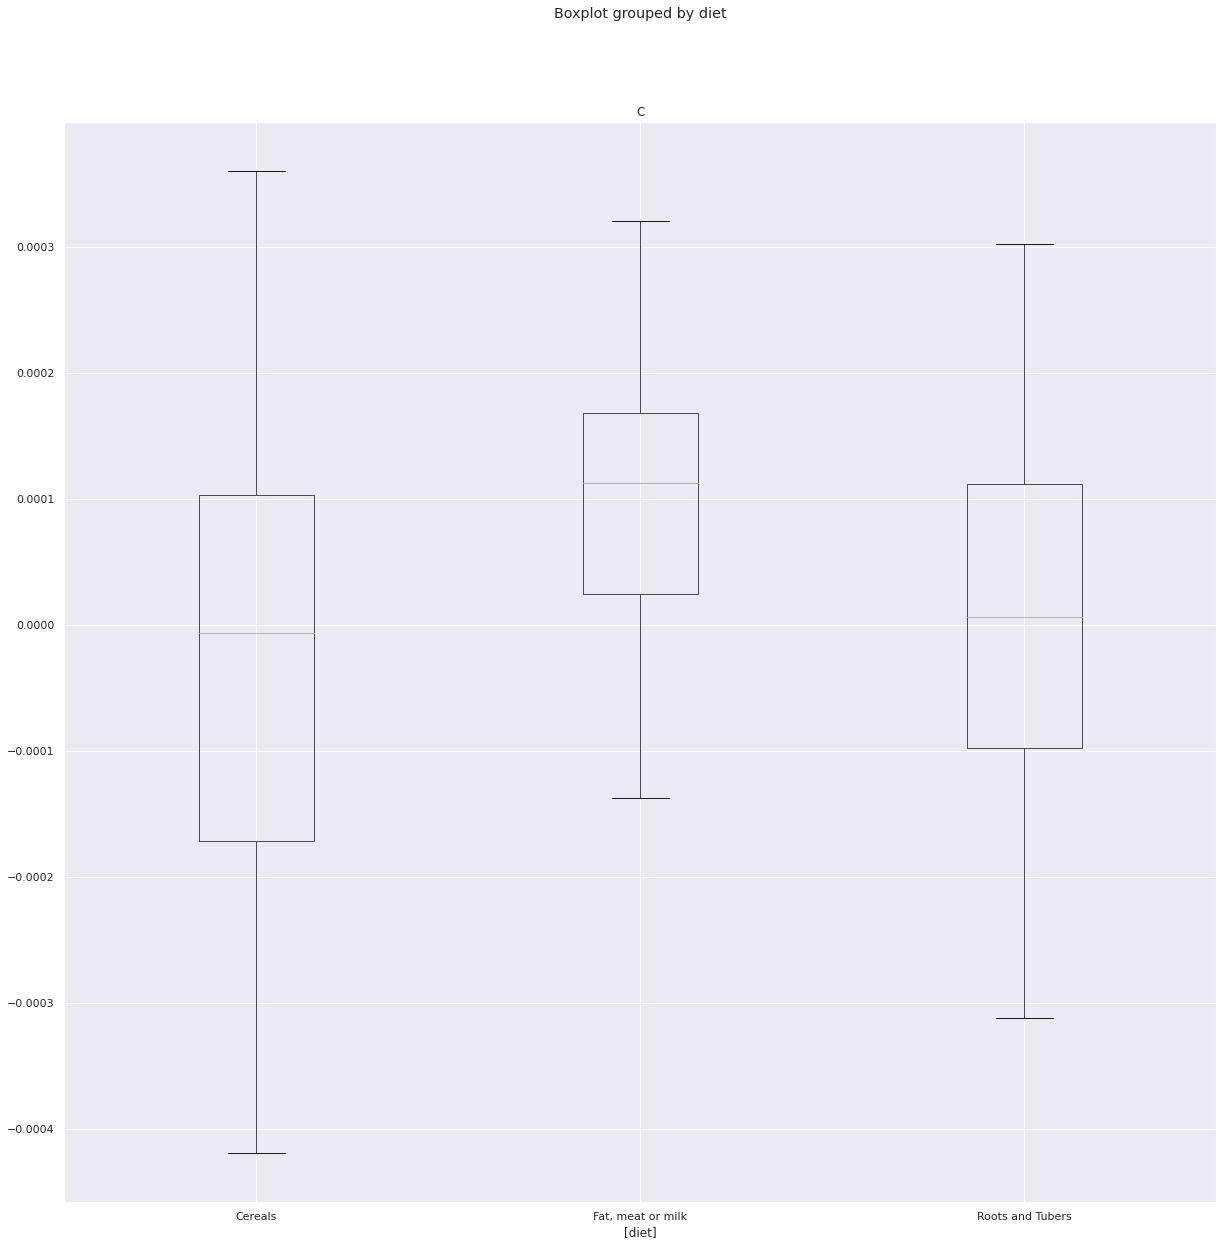

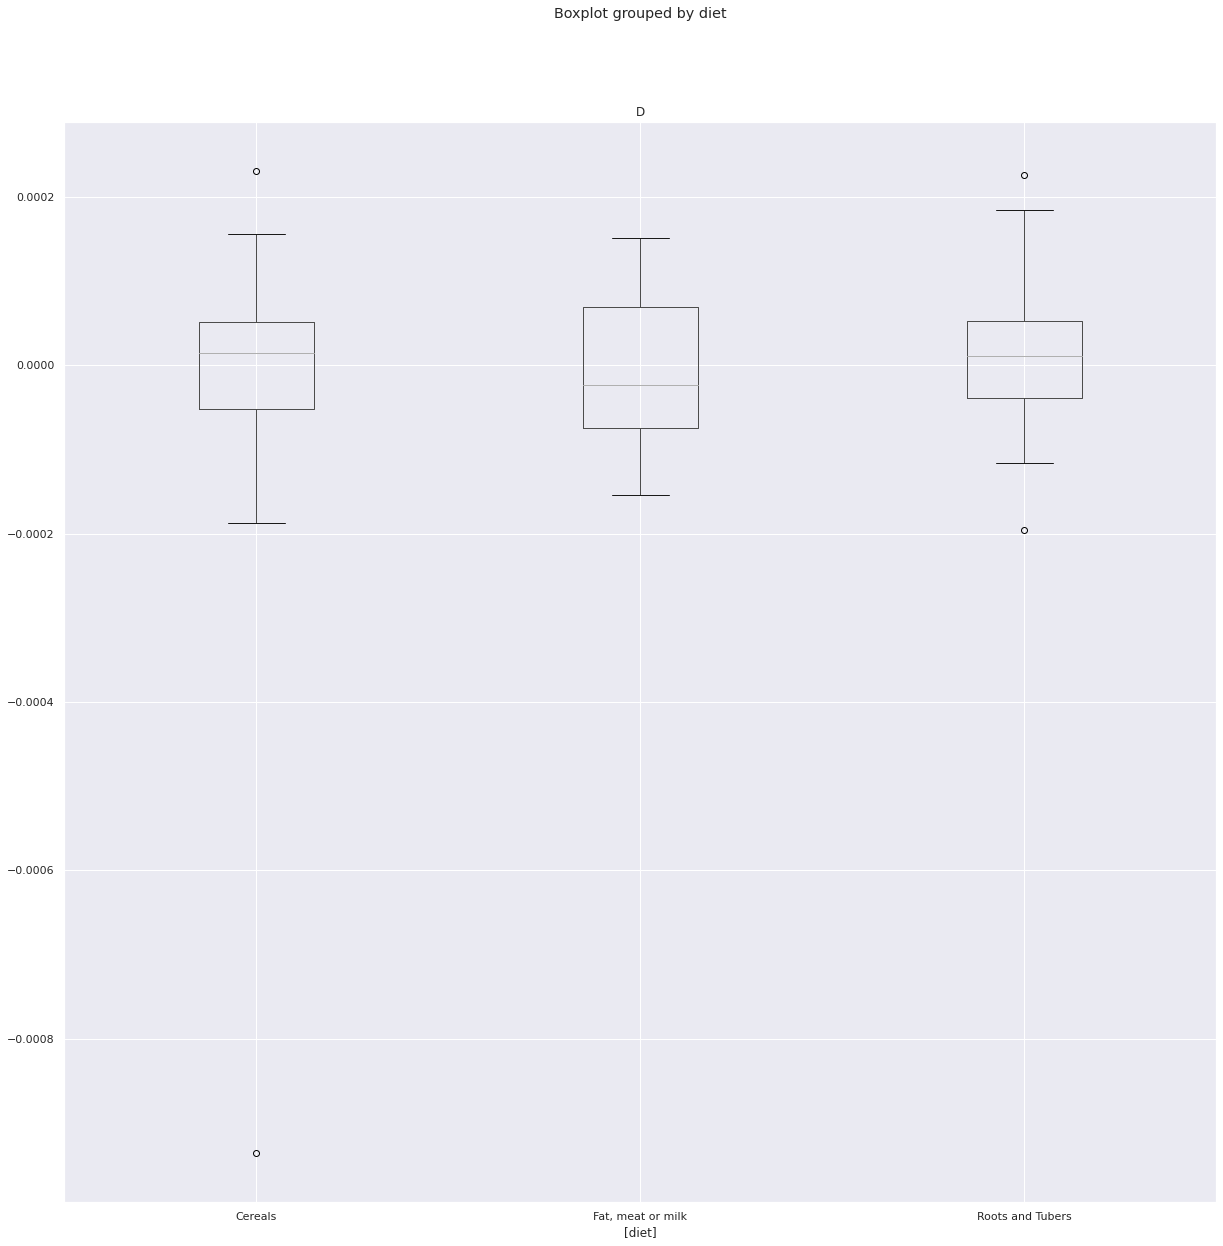

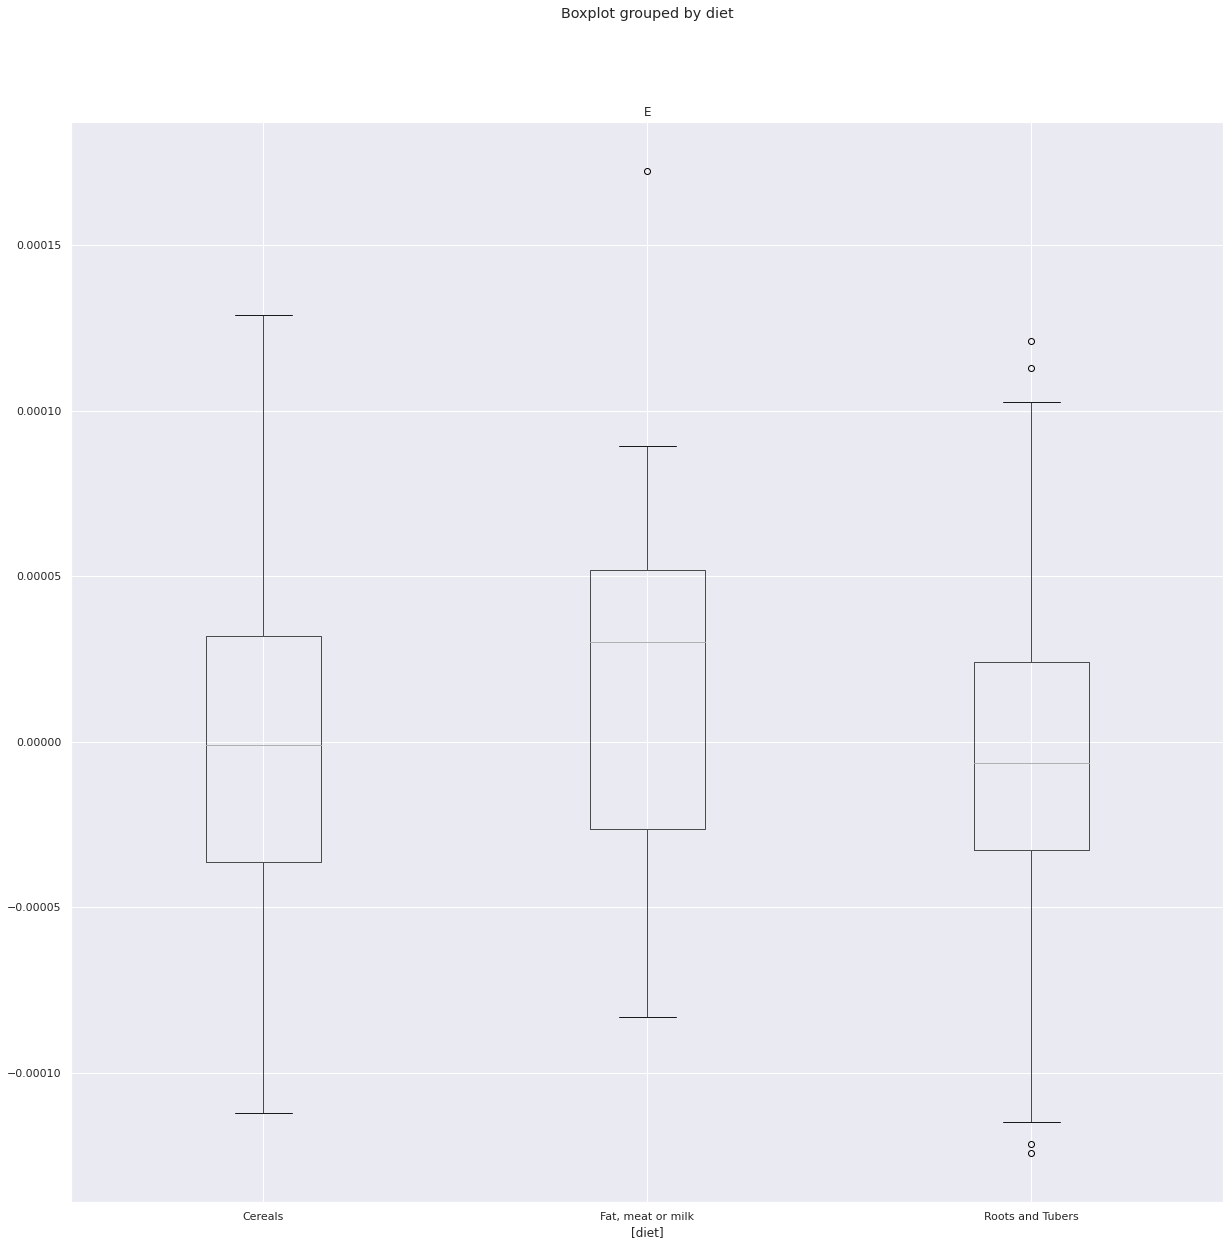

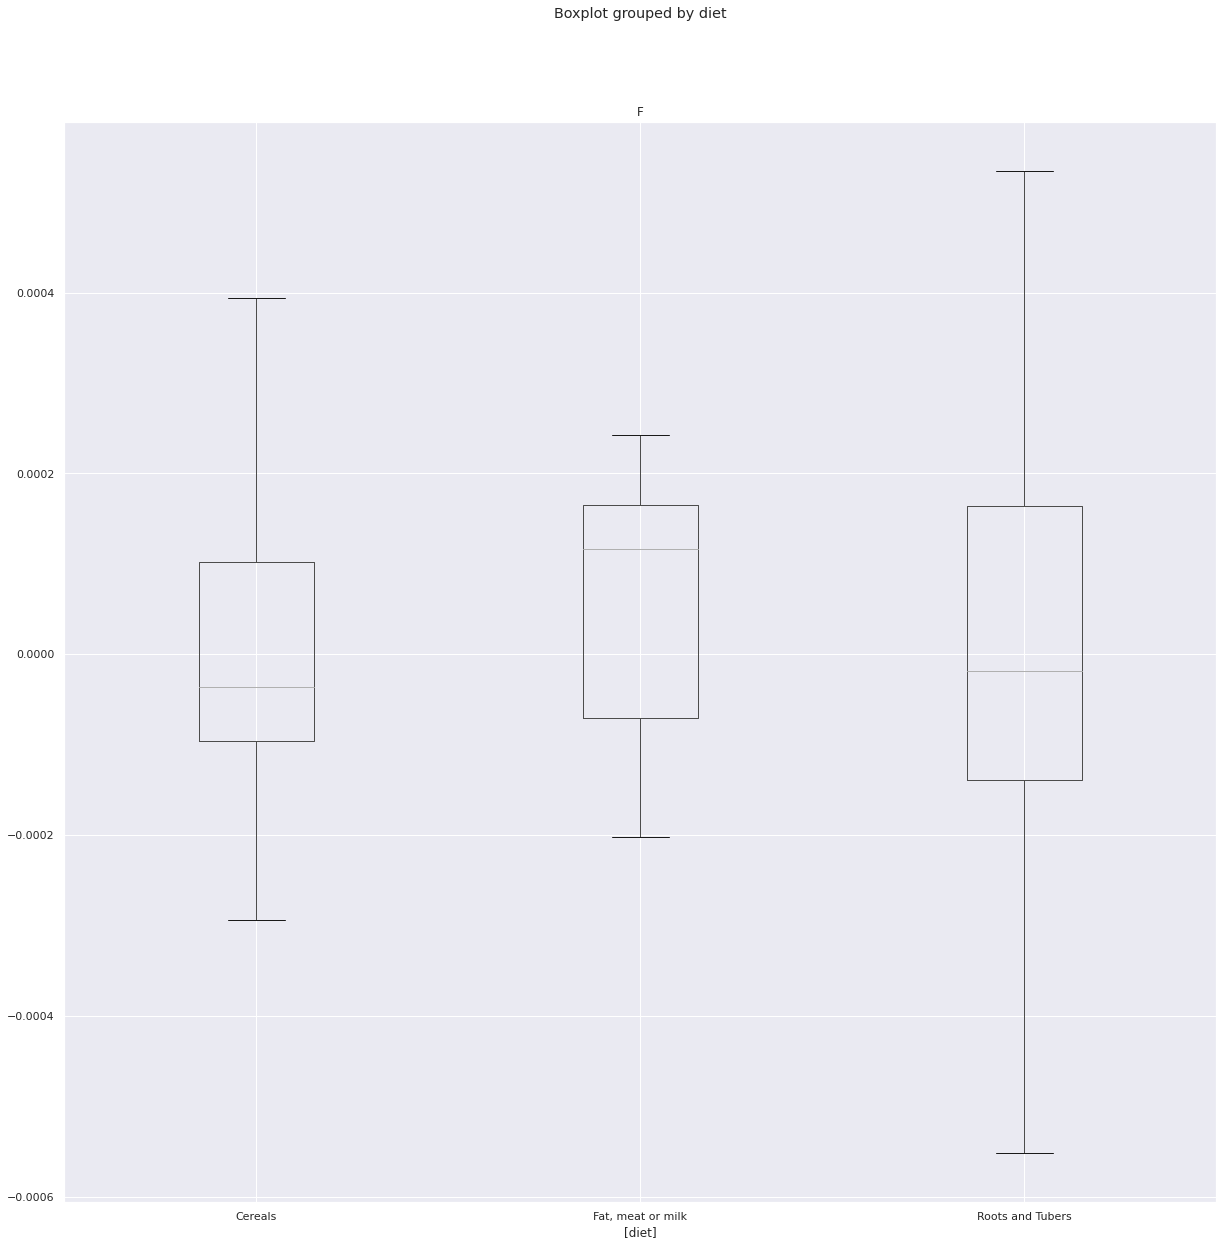

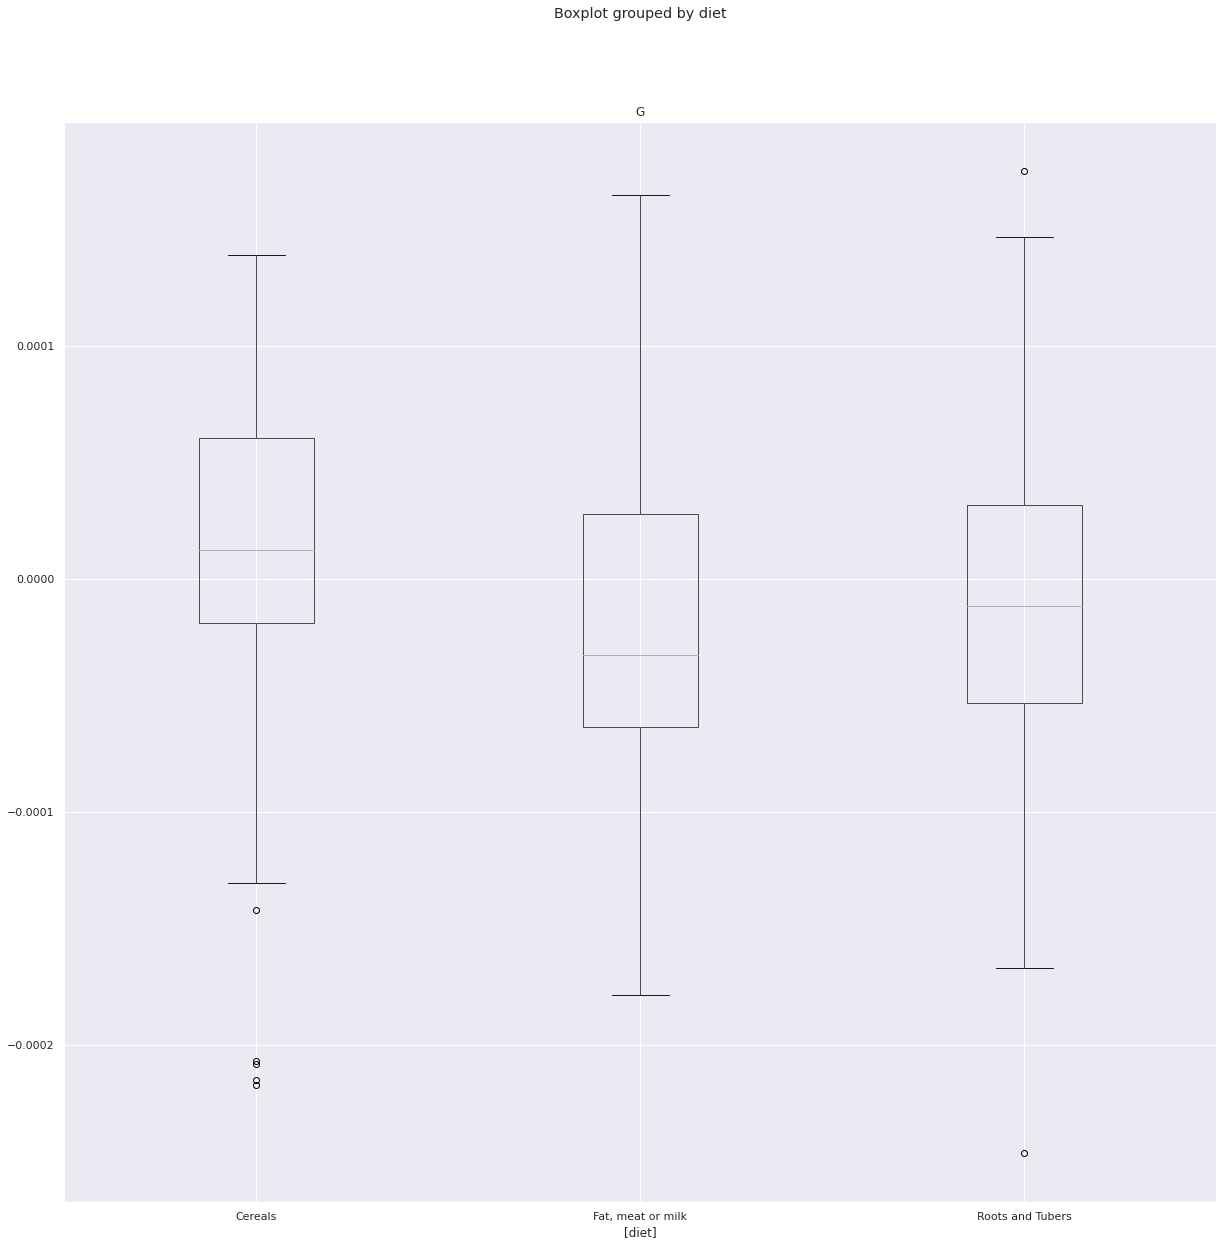

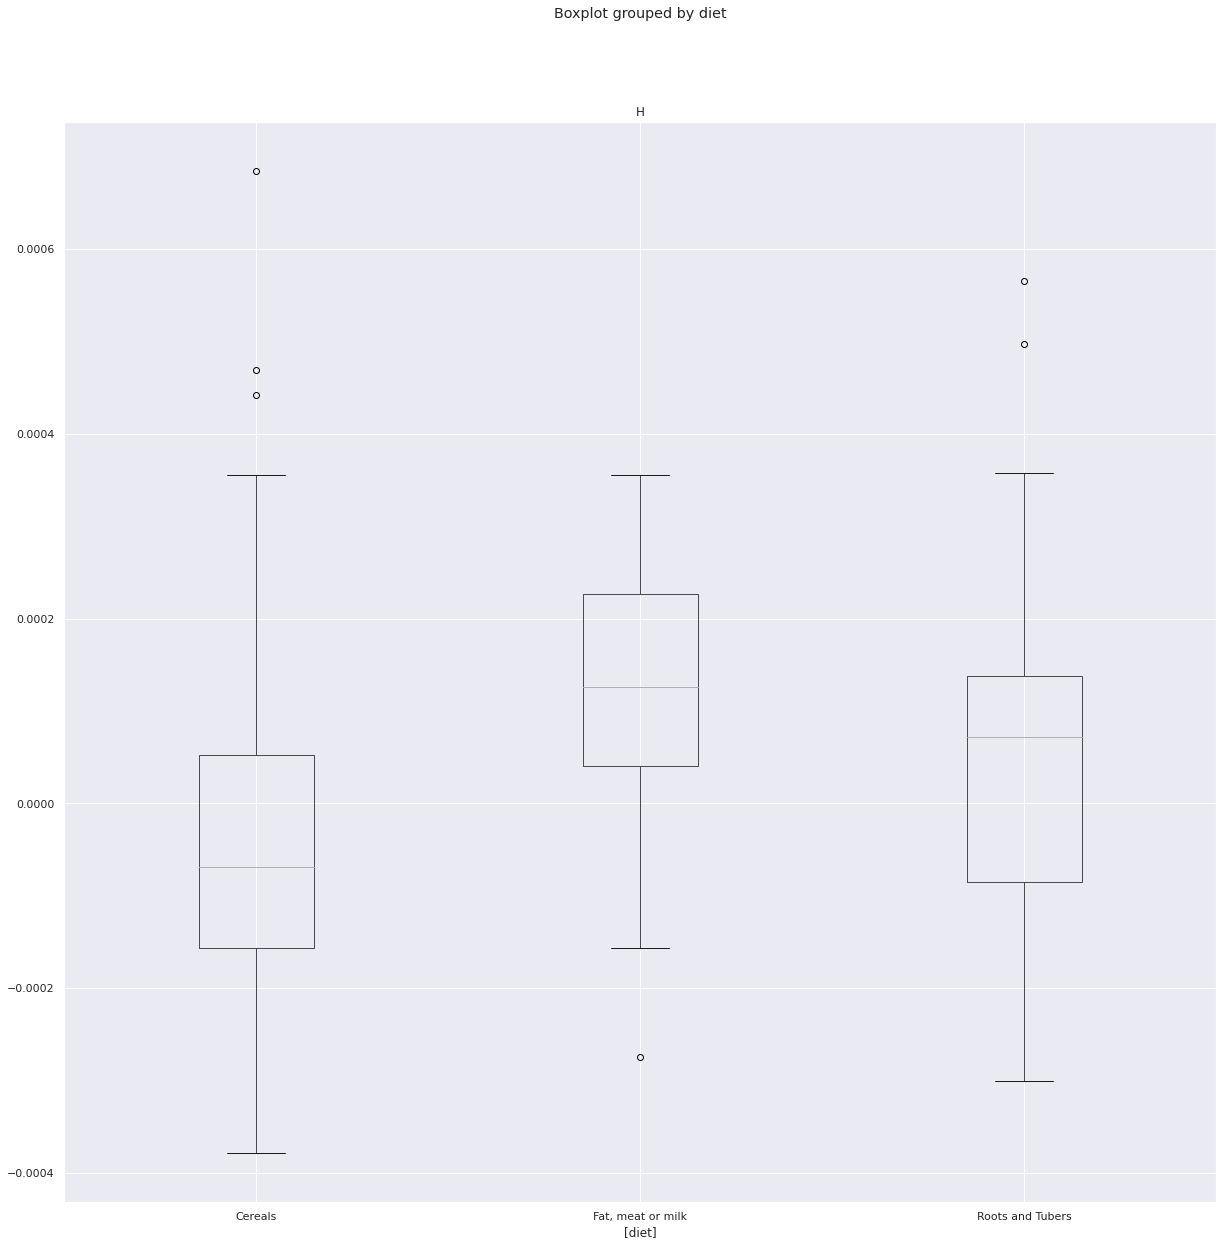

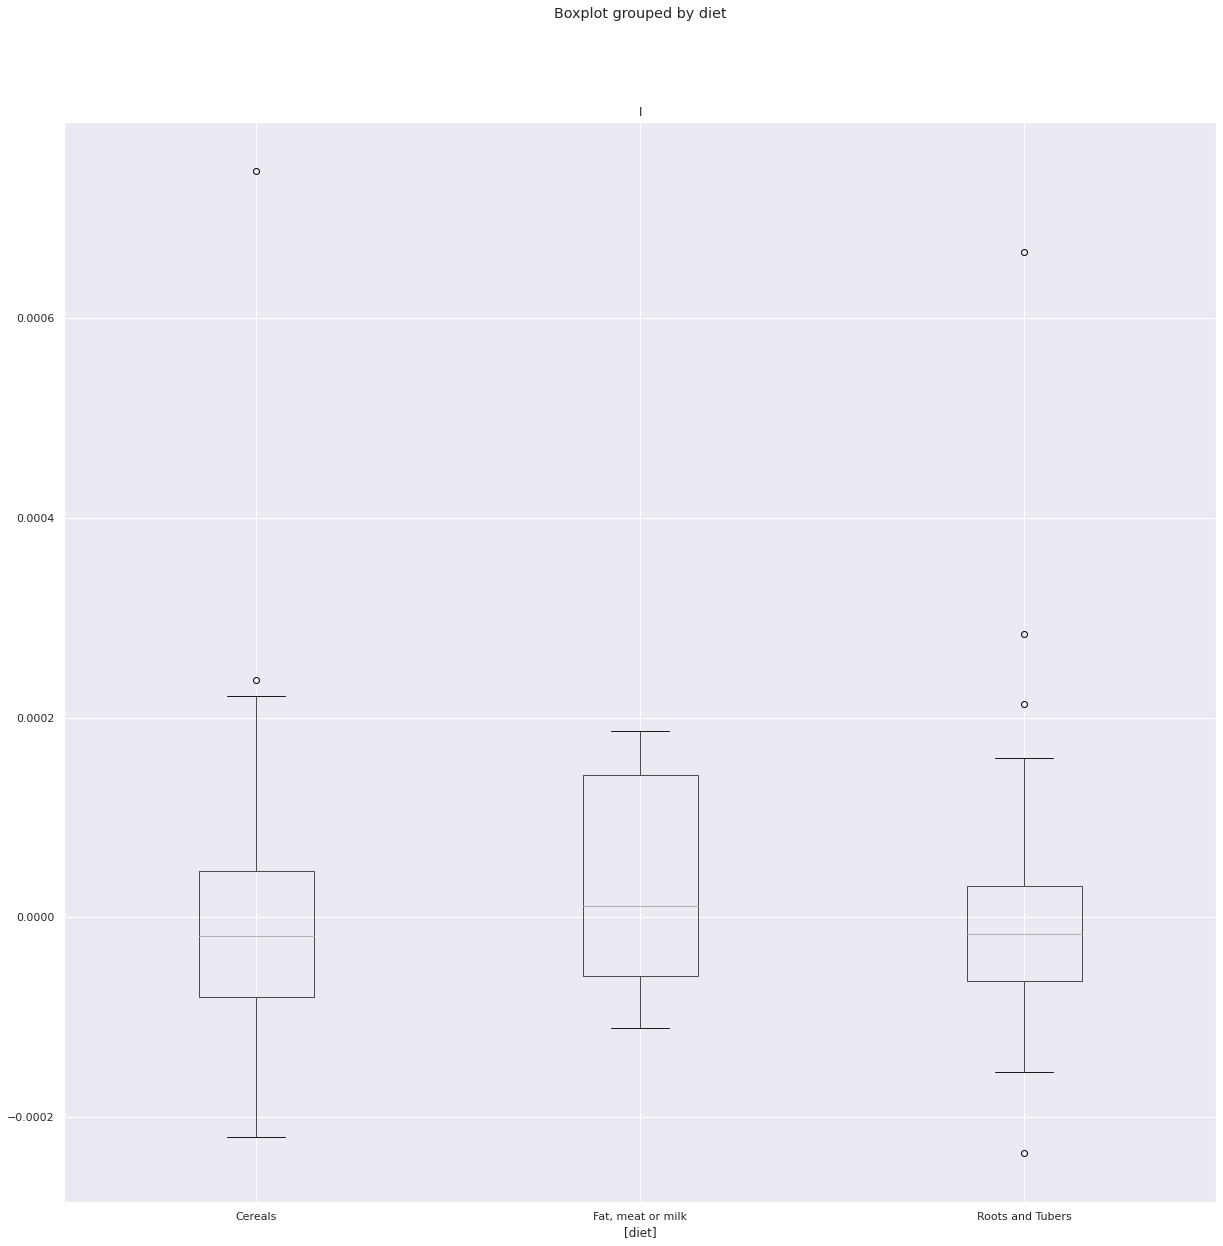

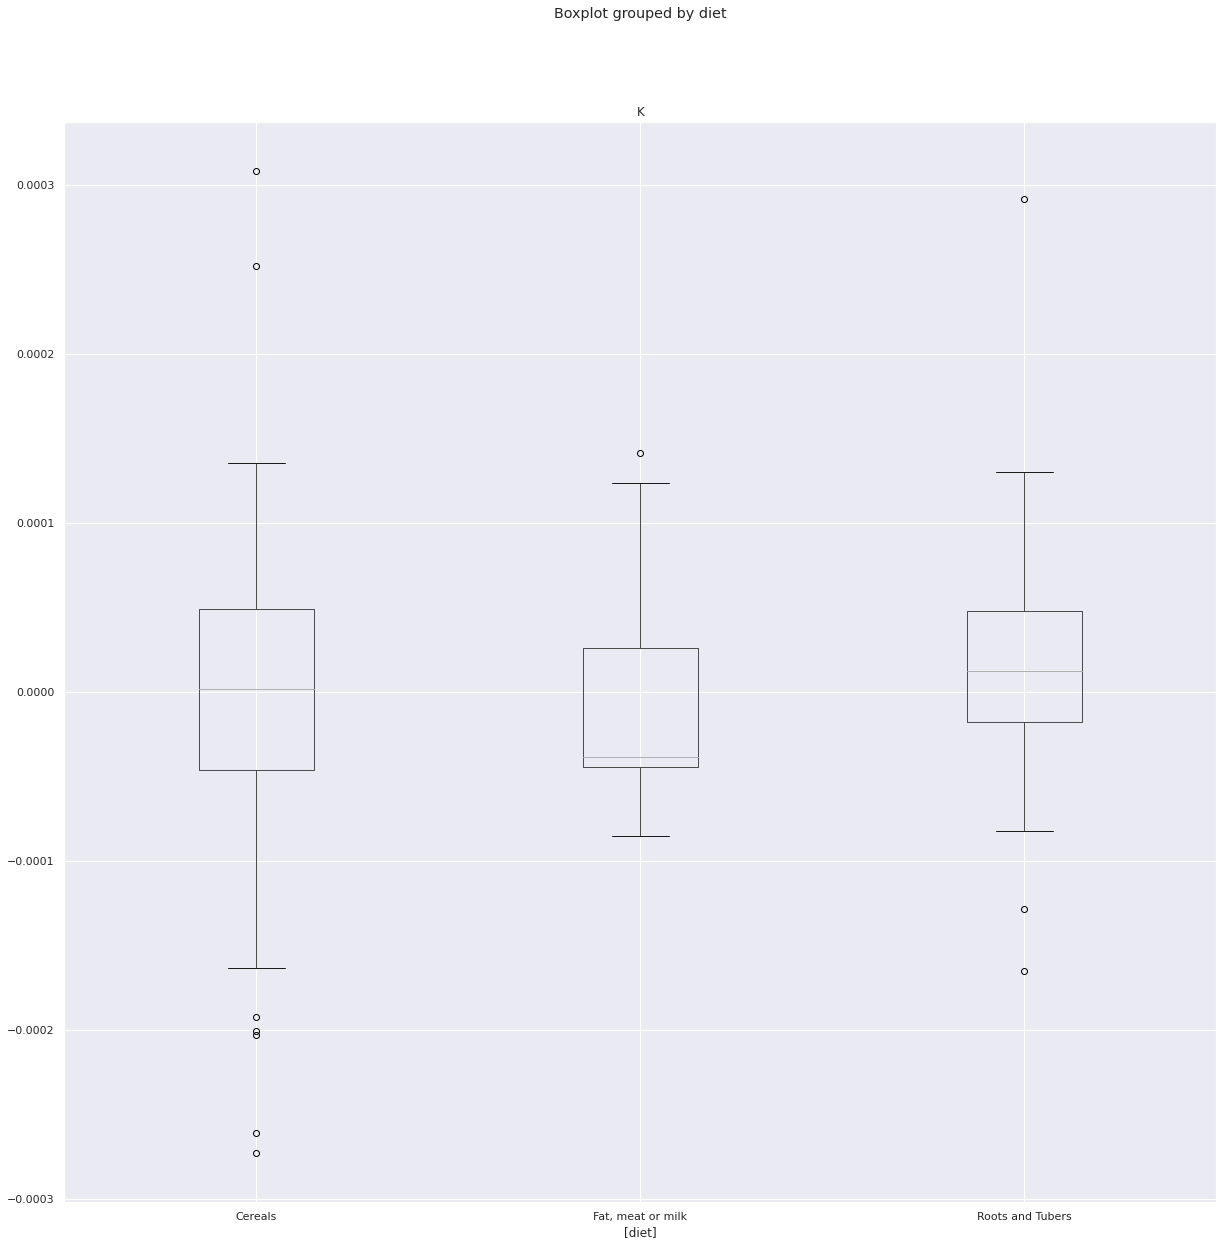

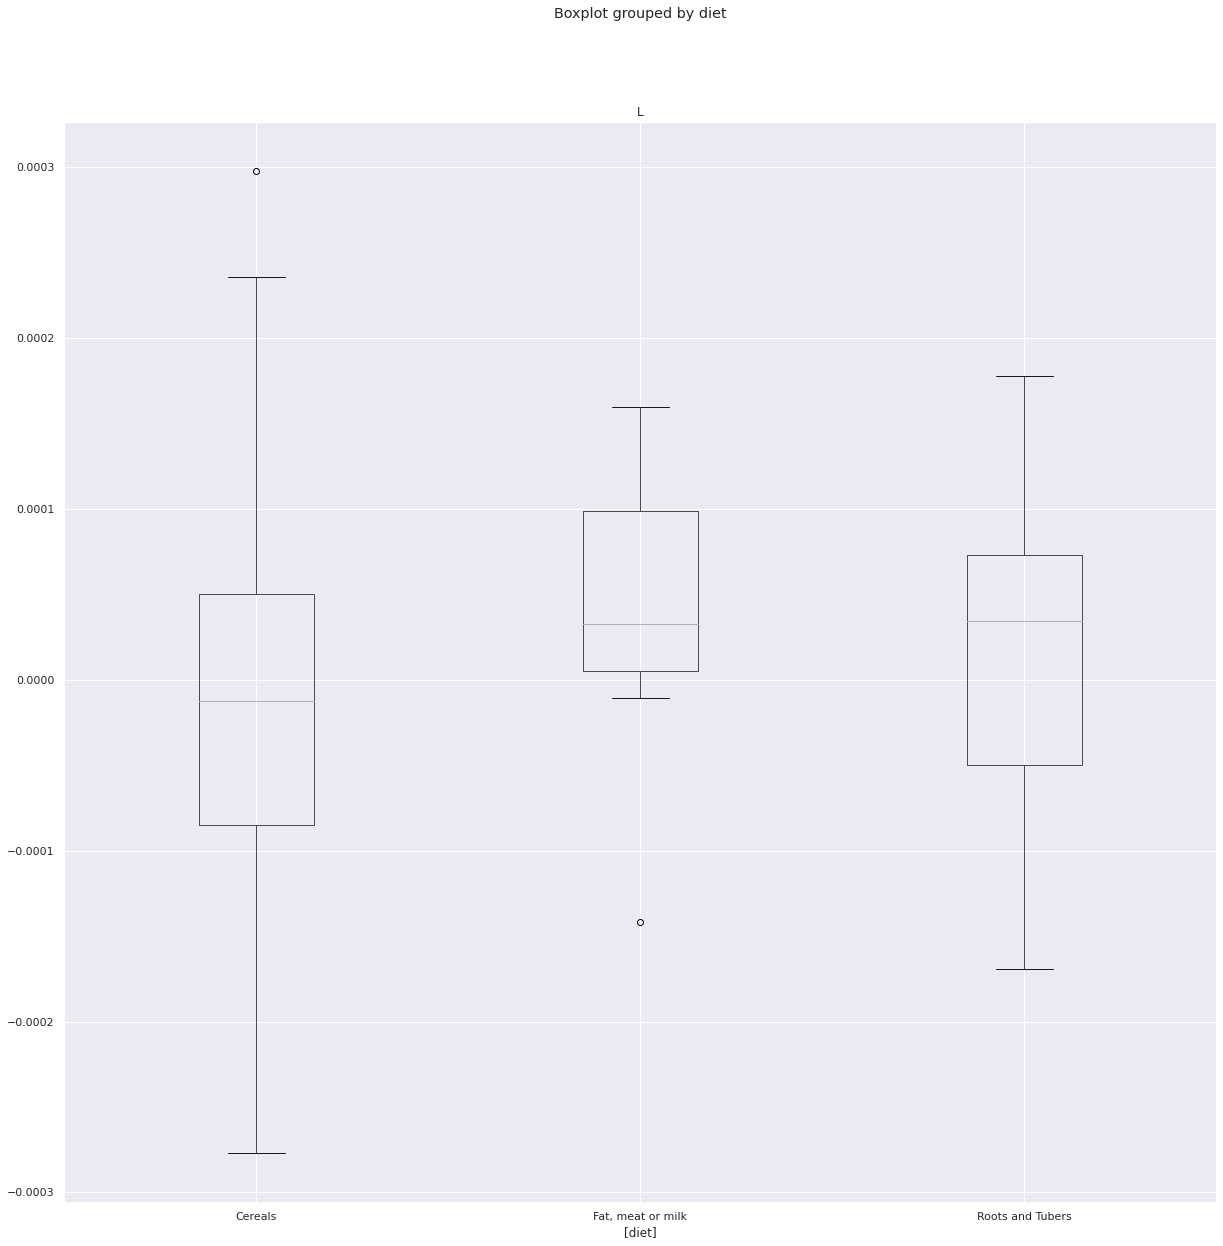

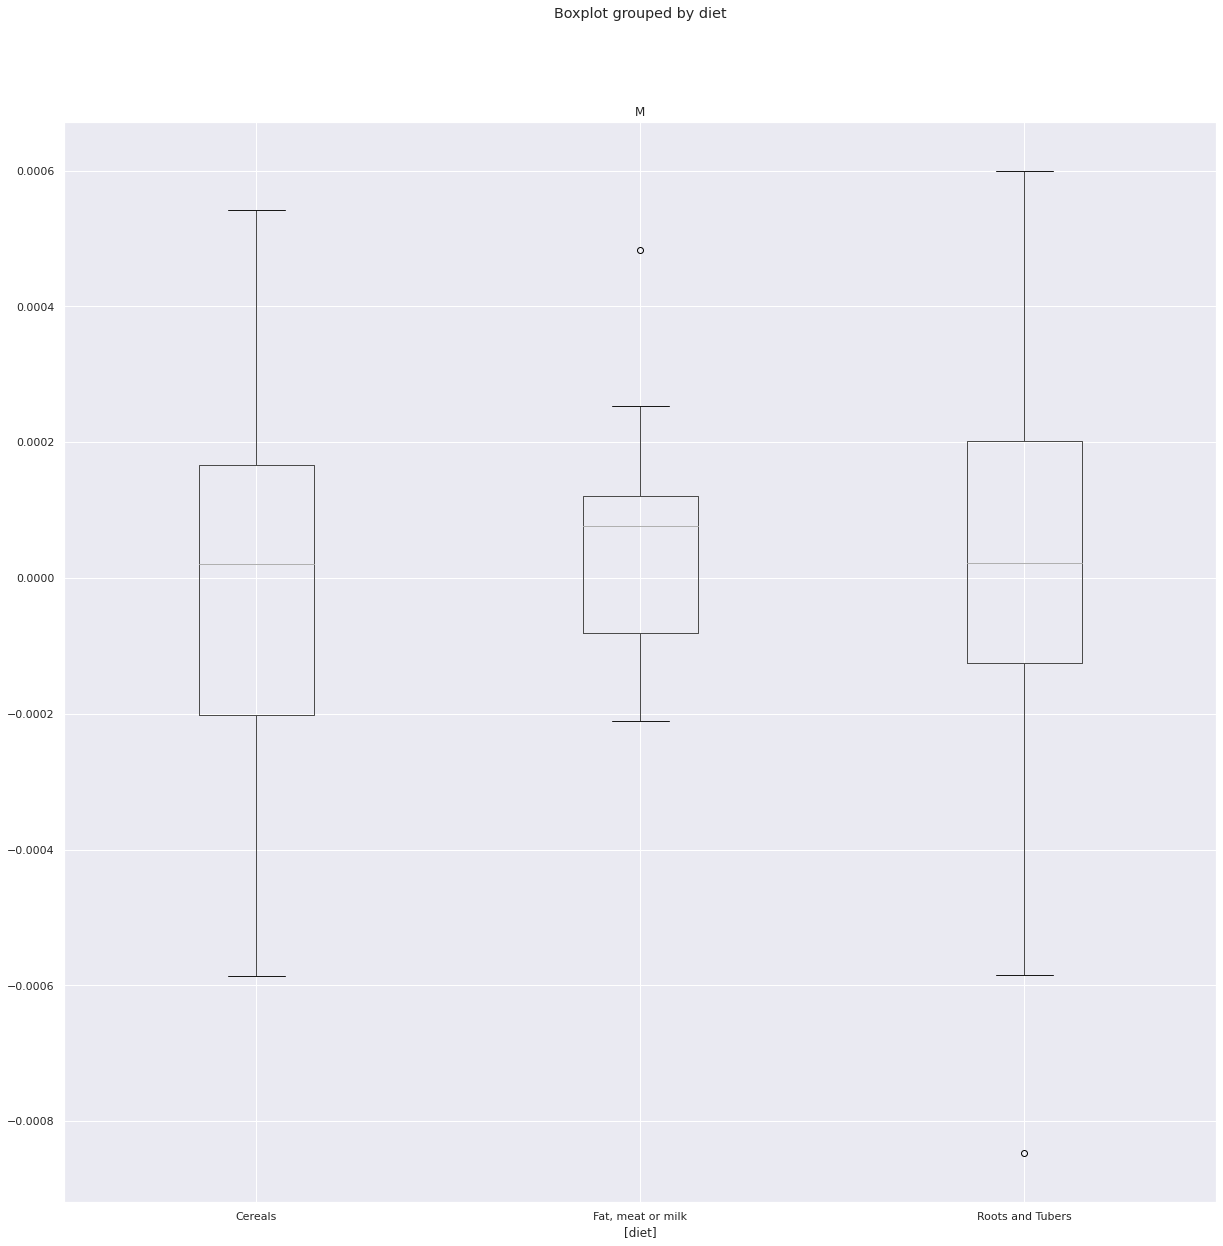

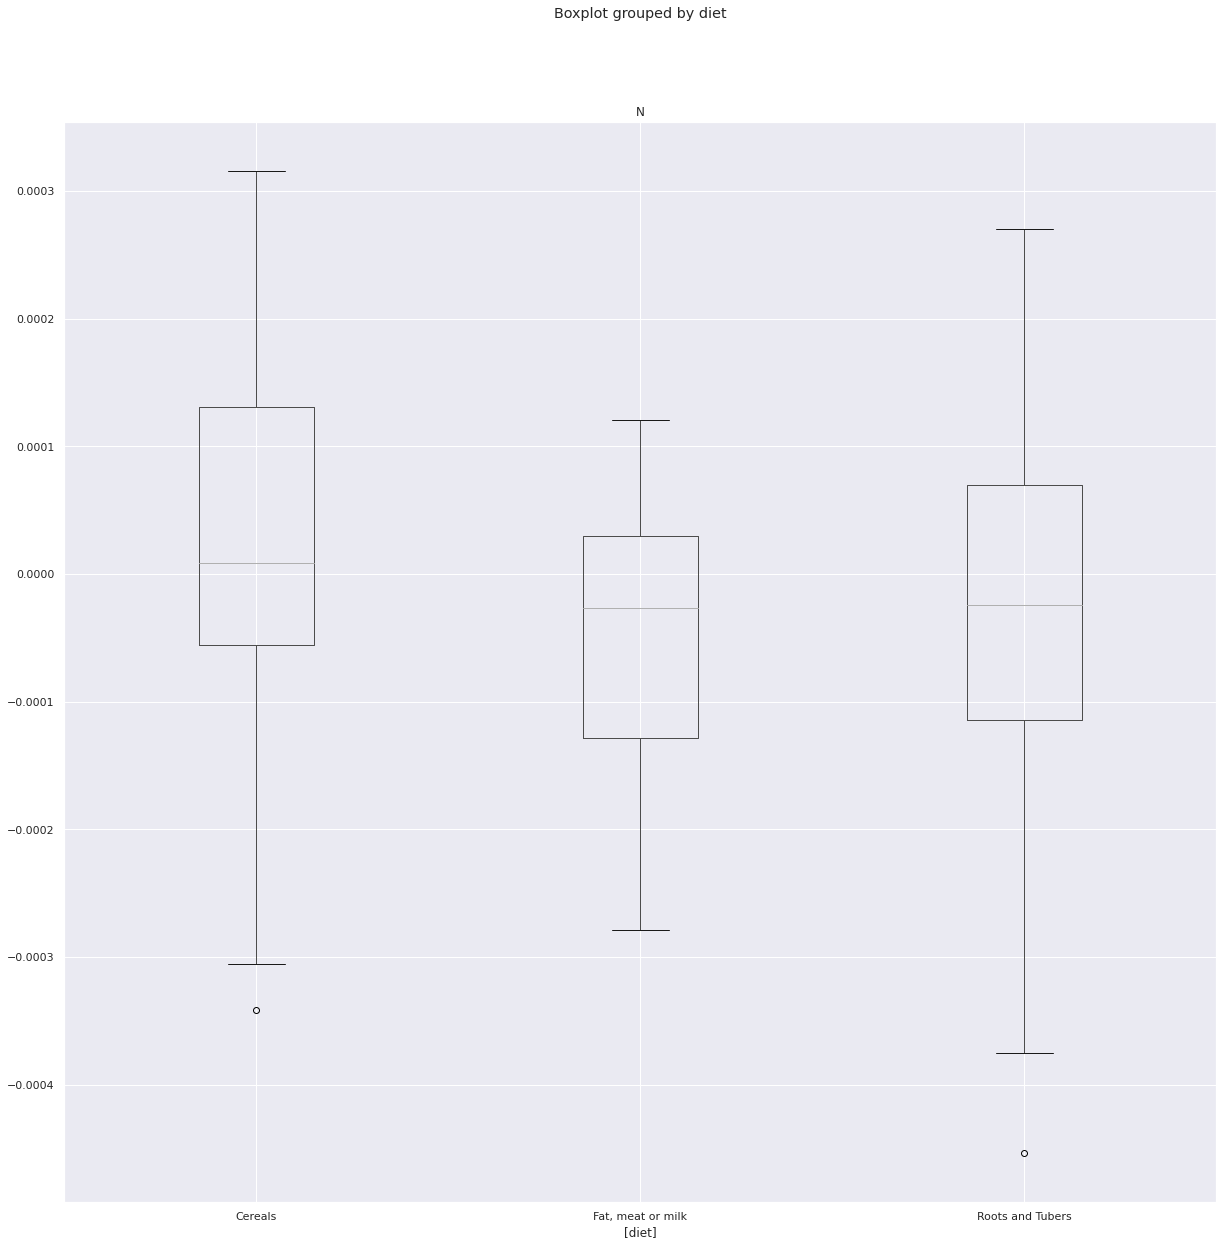

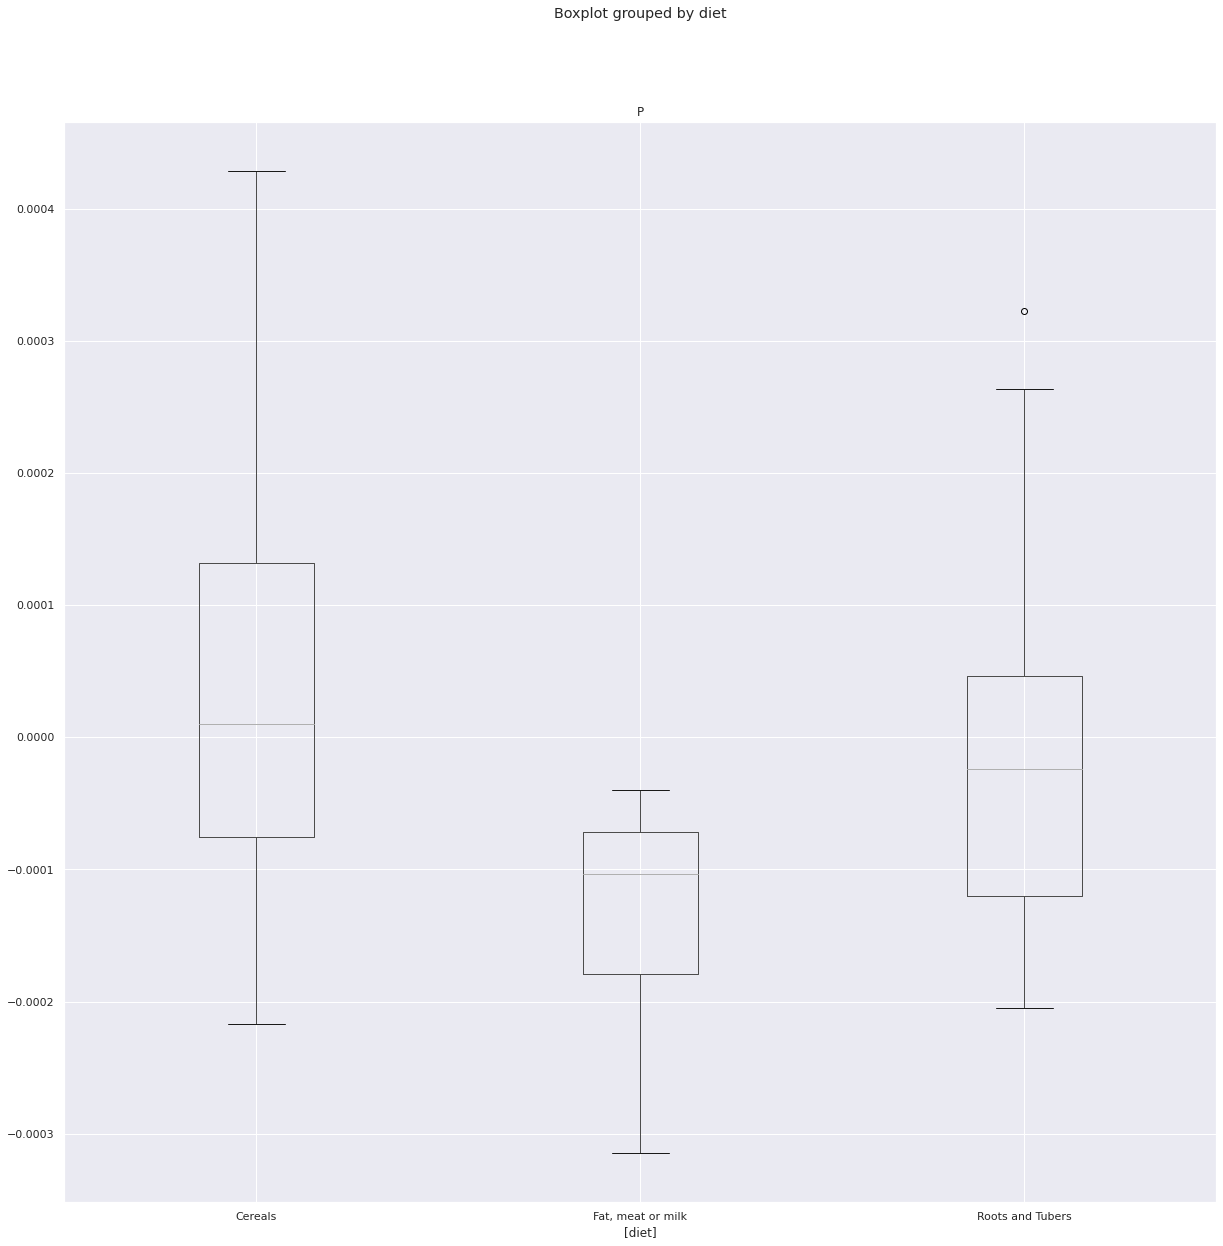

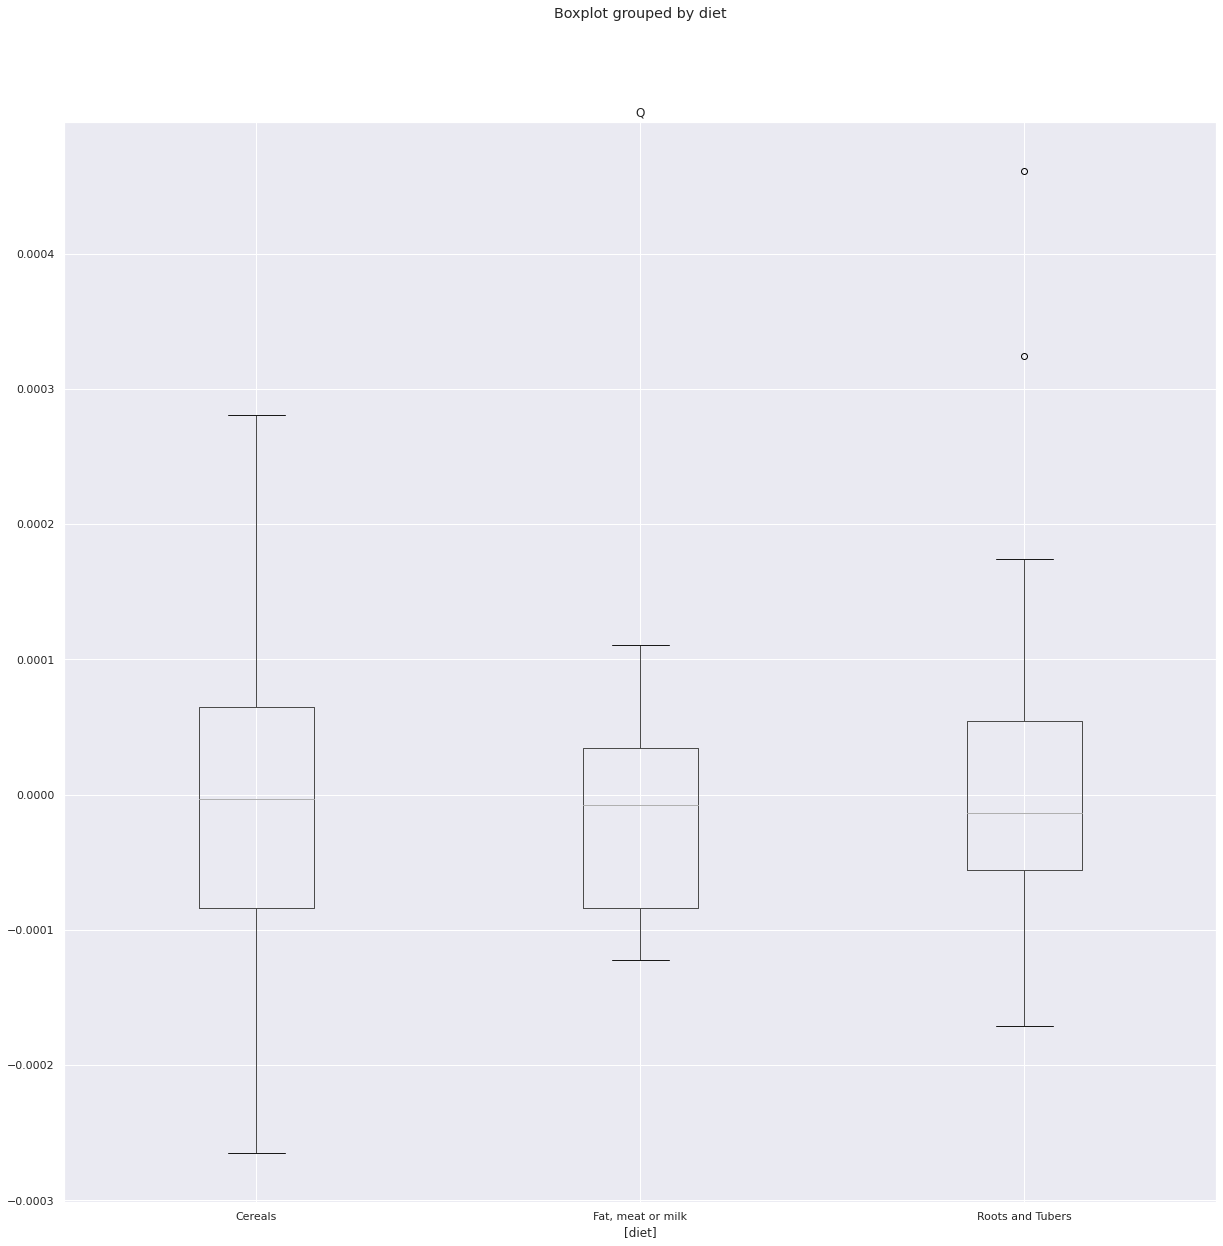

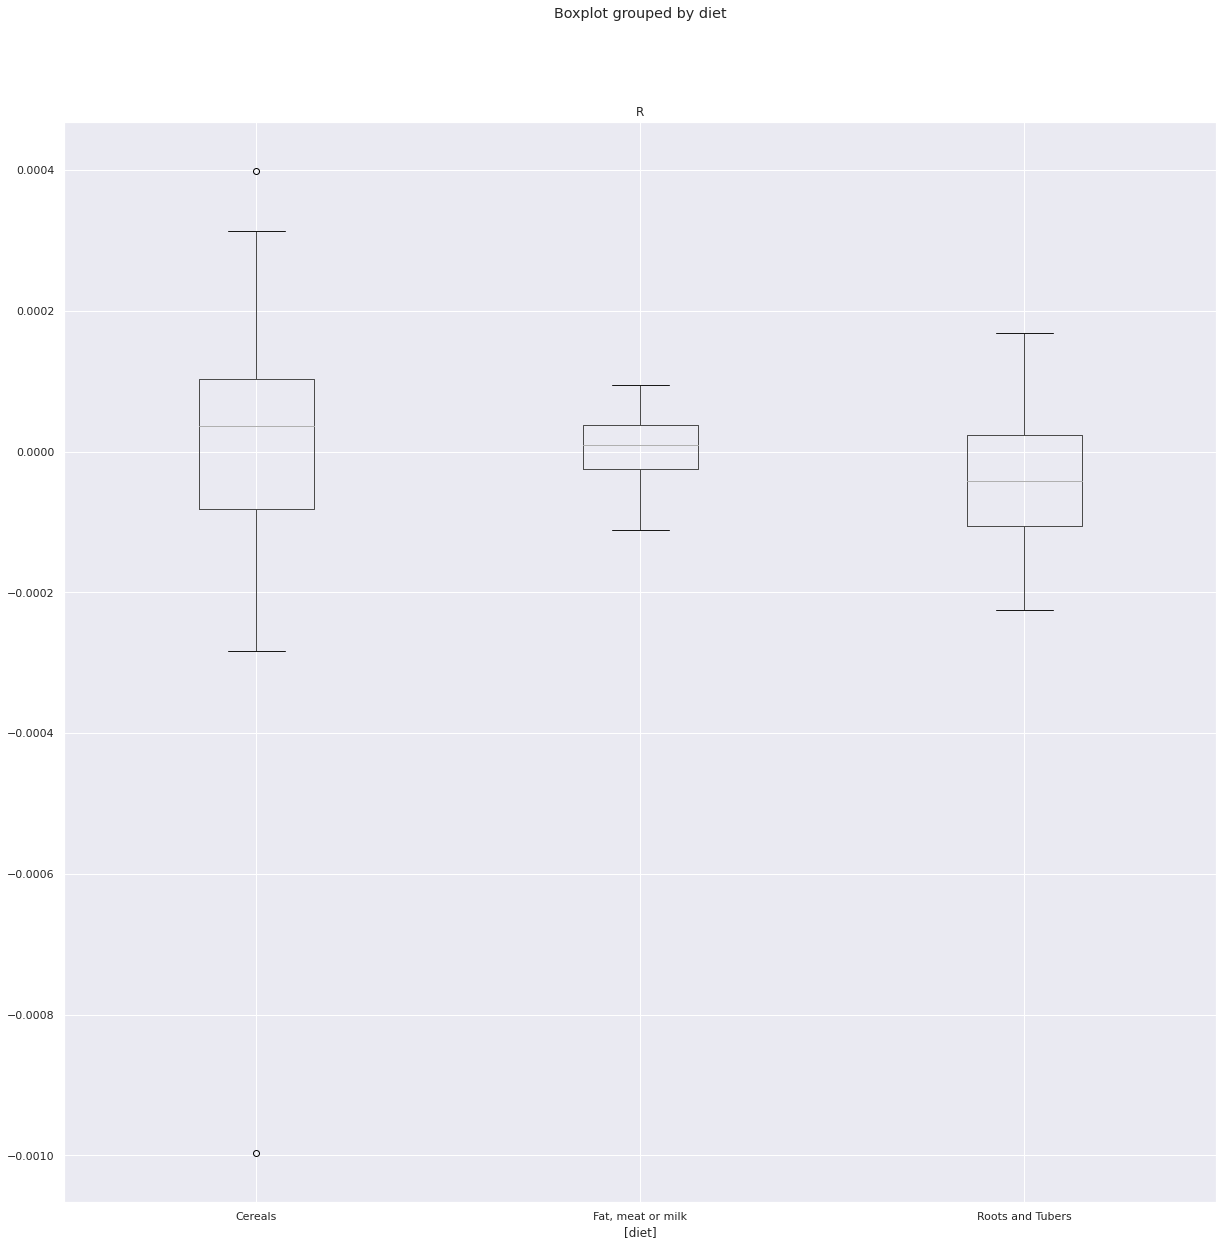

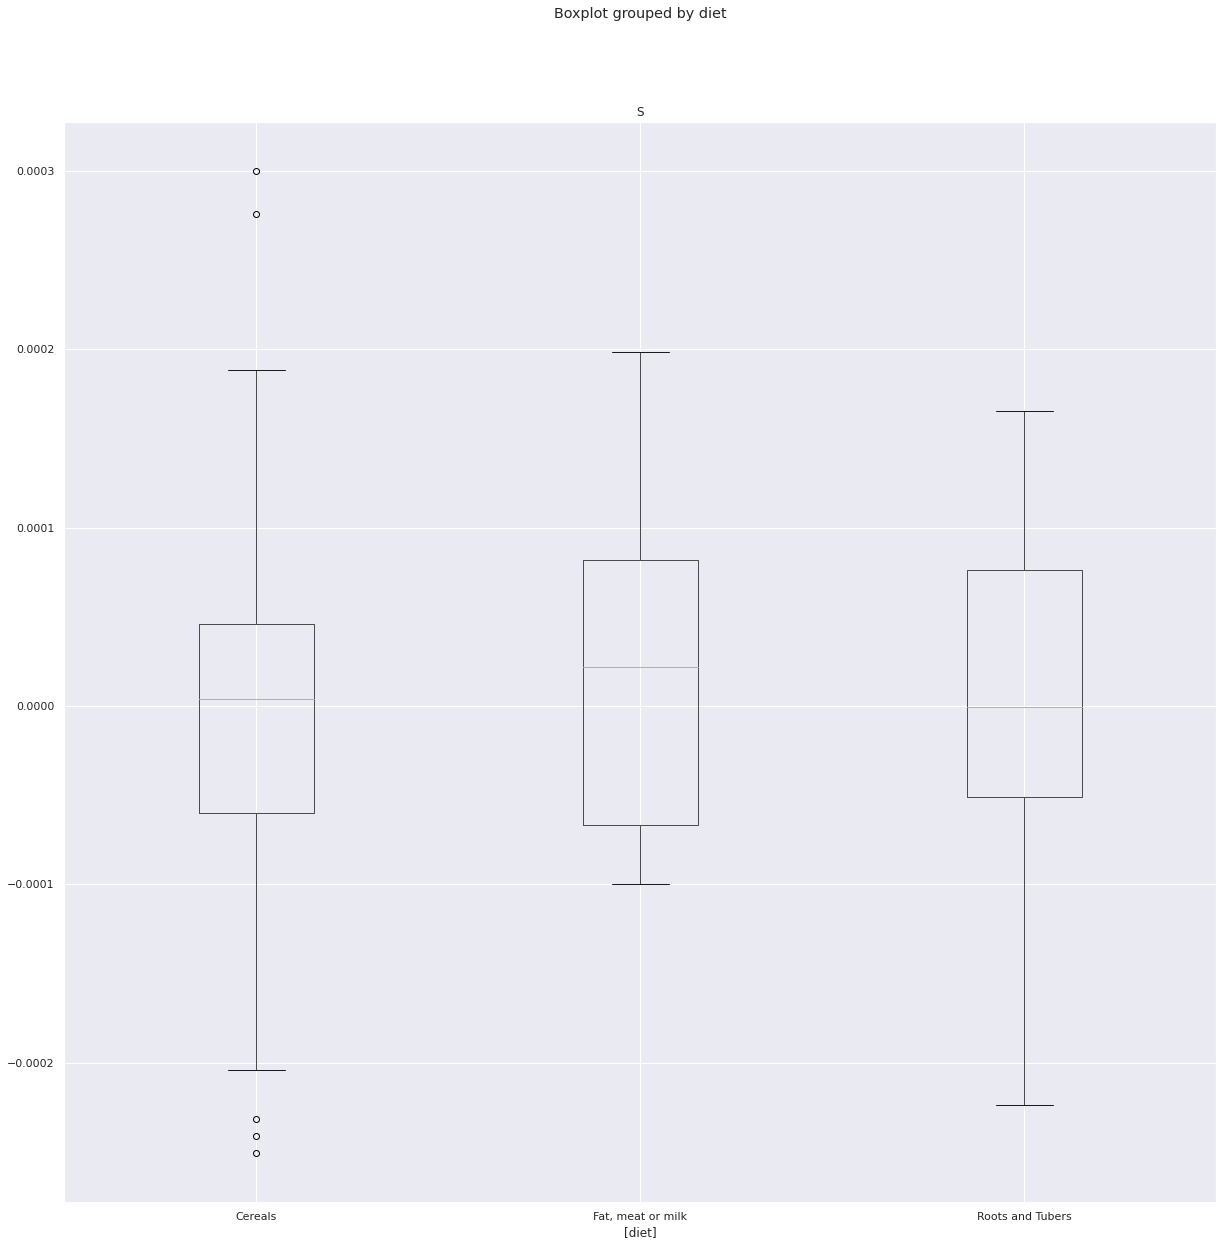

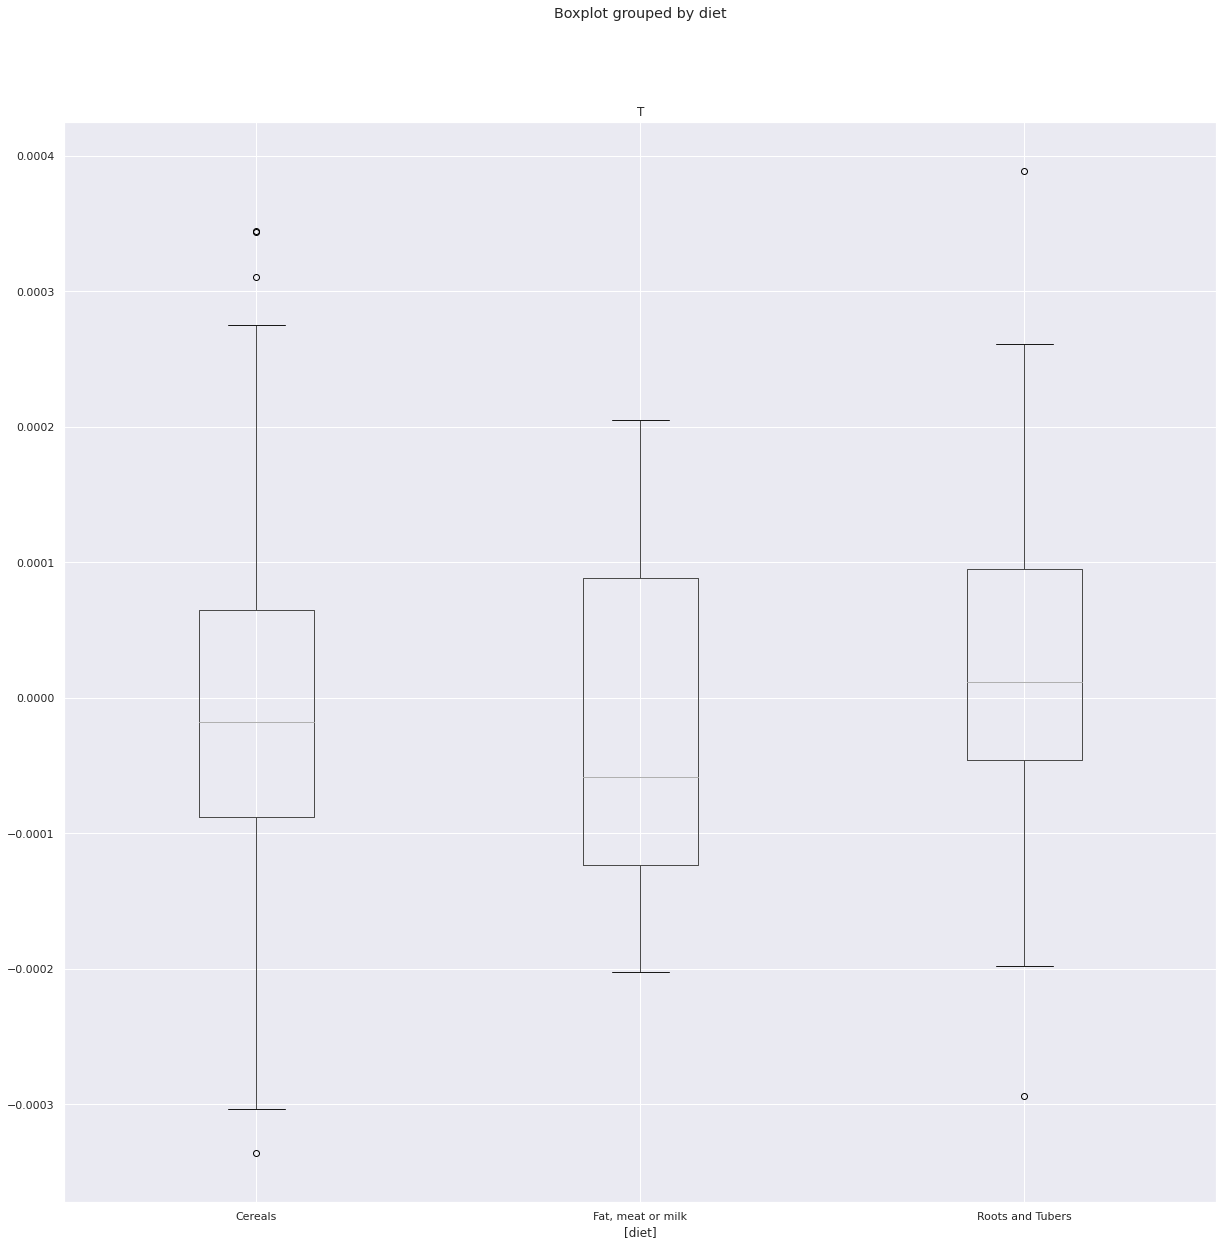

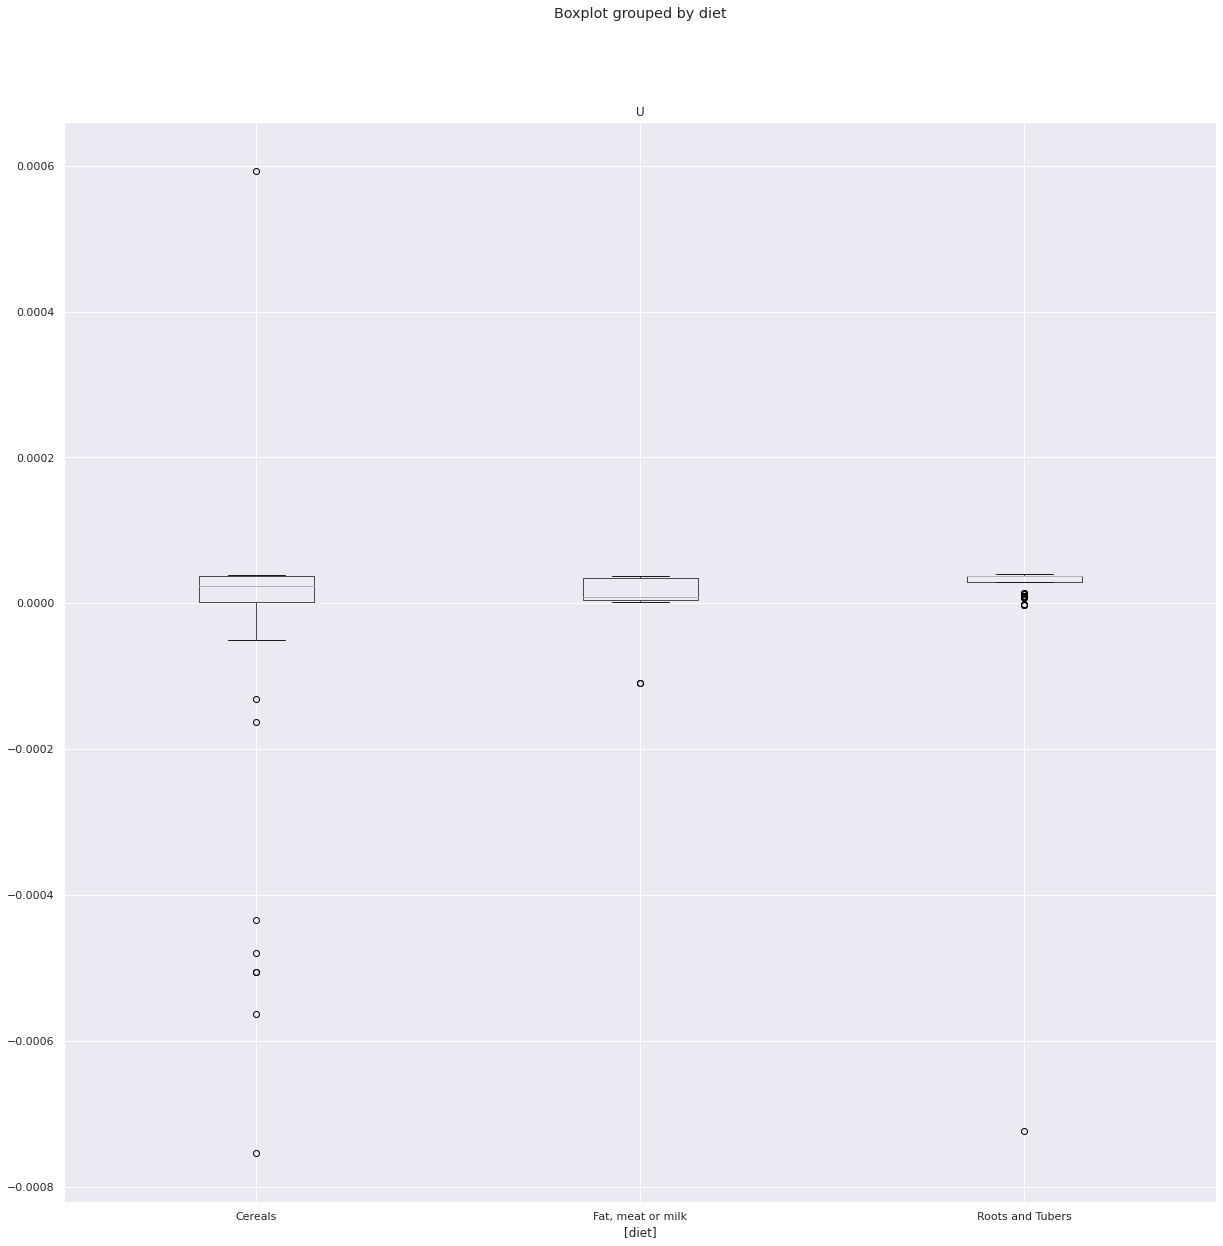

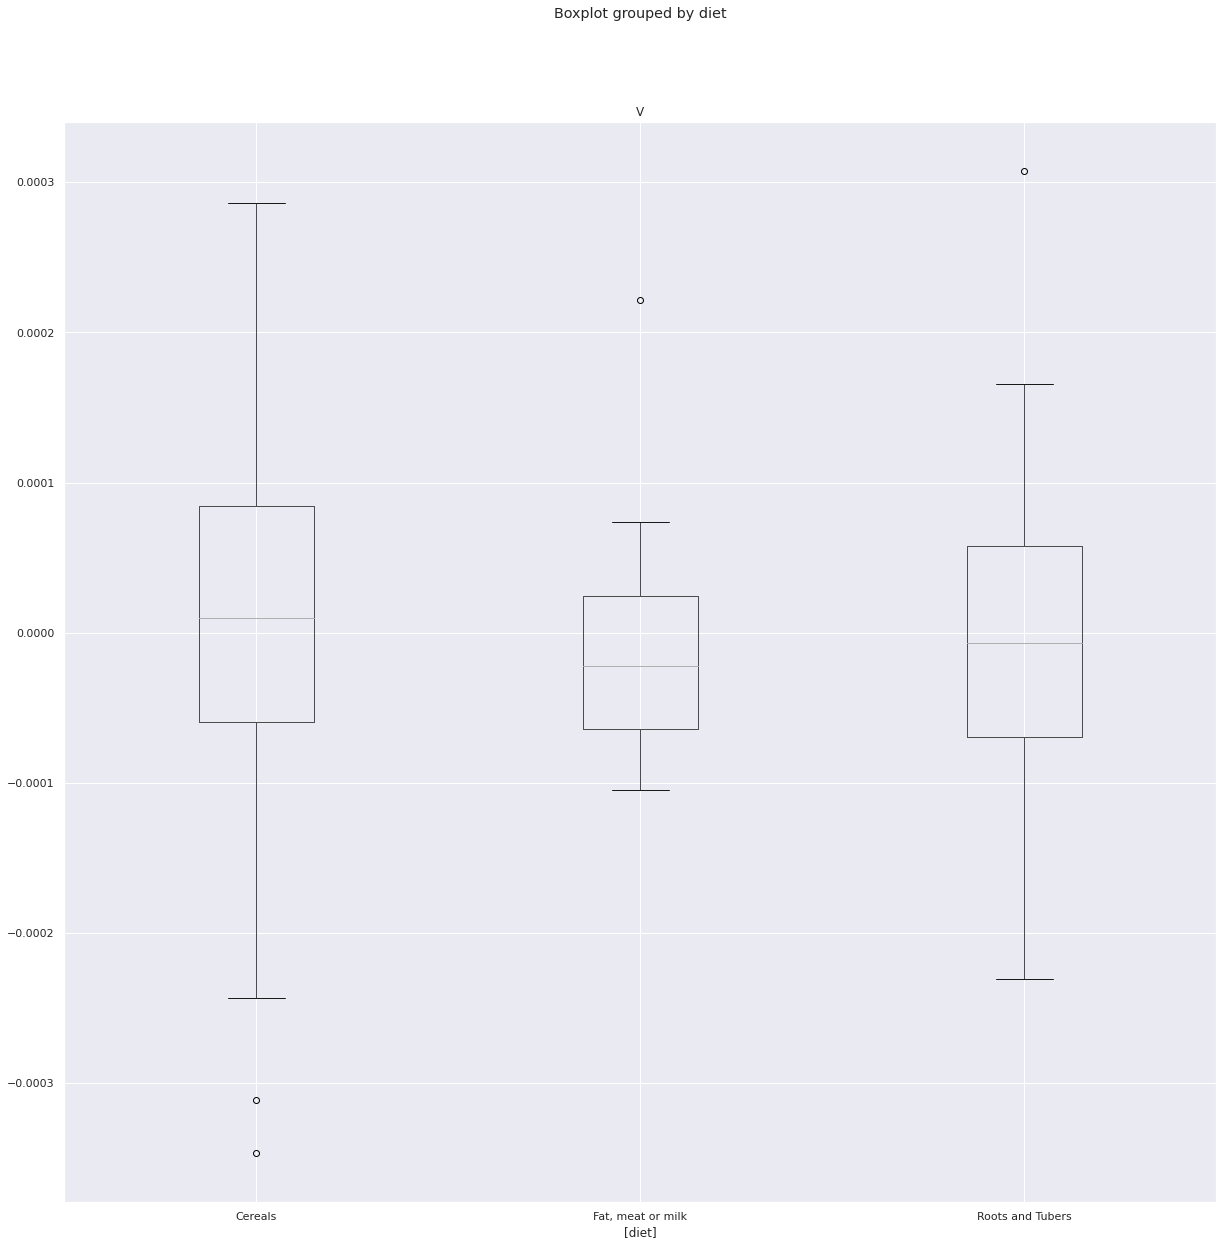

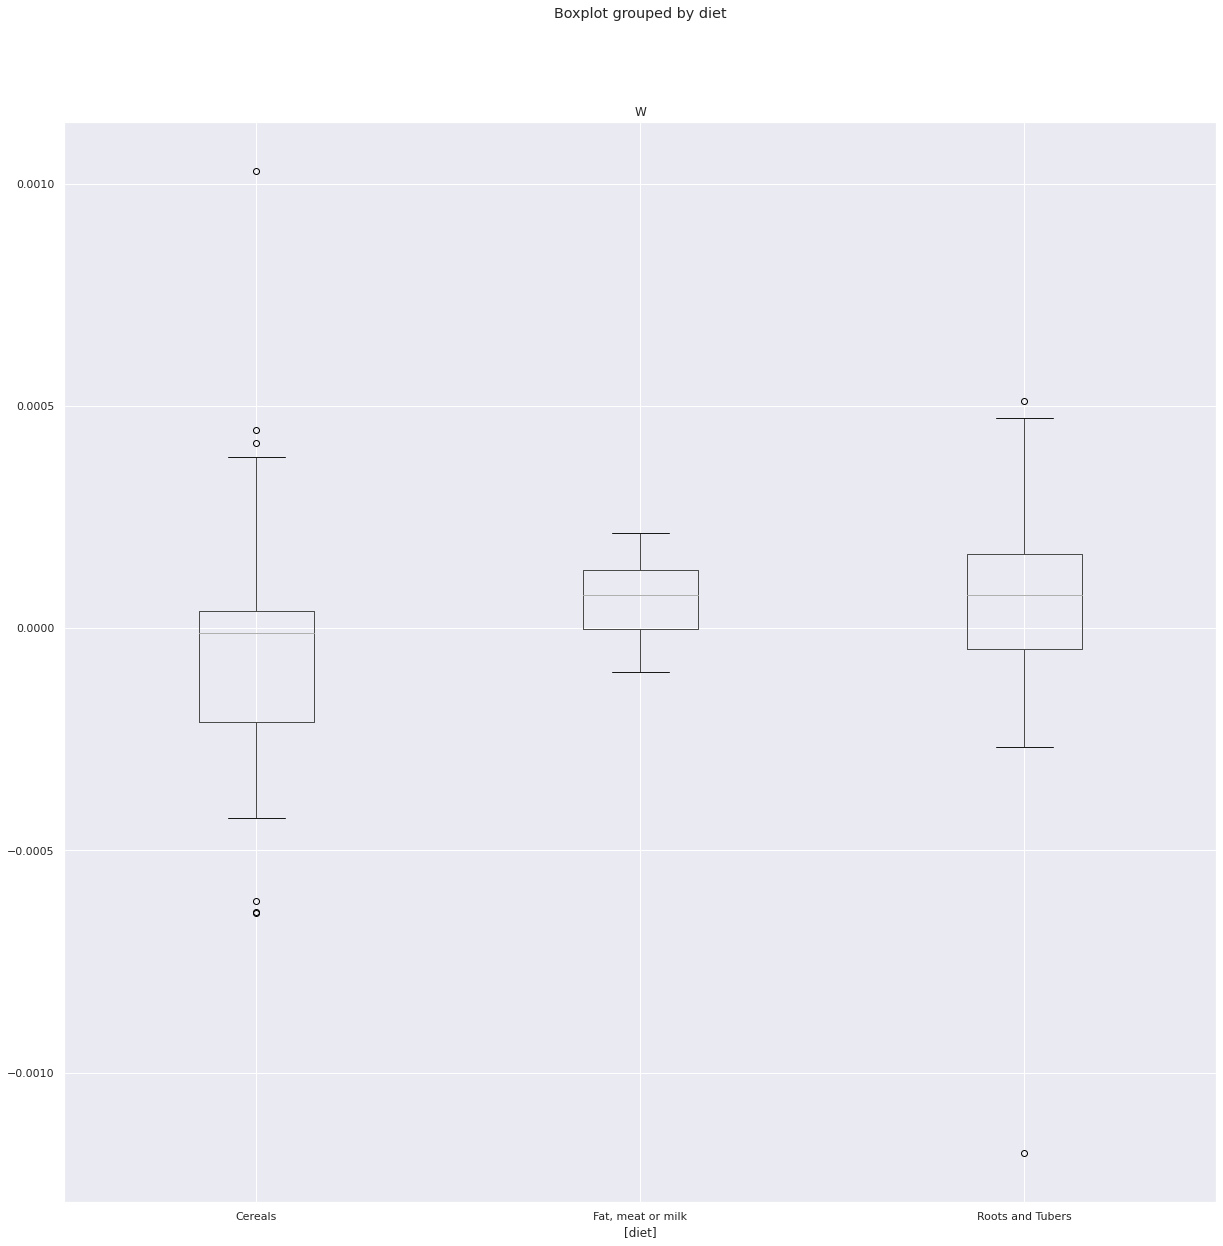

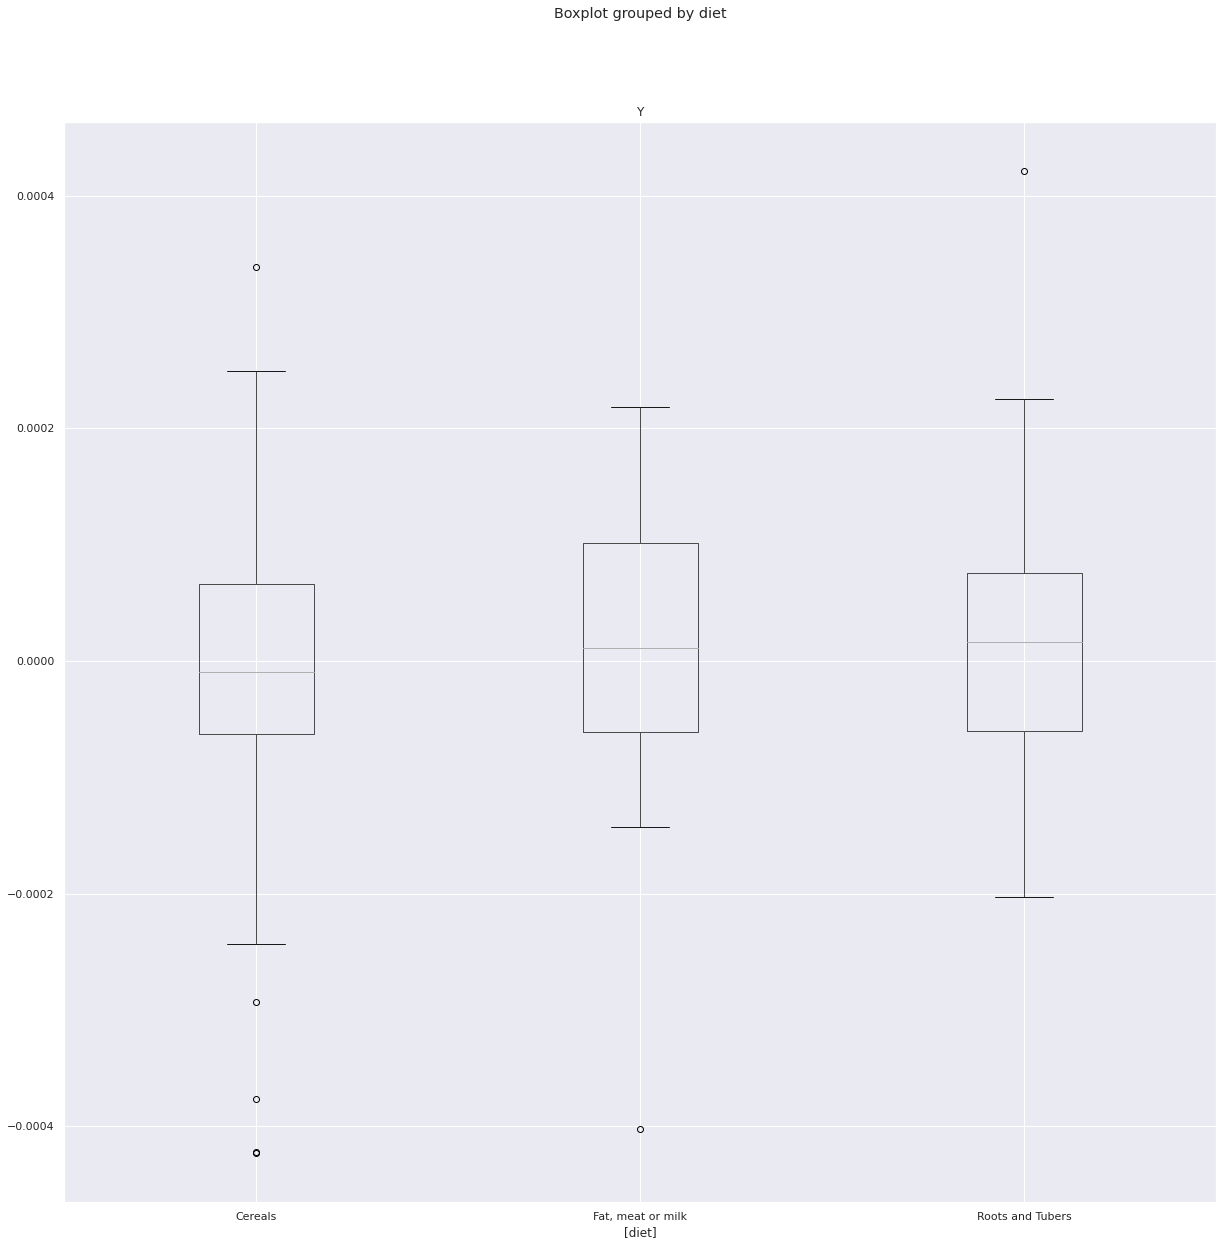

In [30]:
# Boxplot of the single amminoacid divided for diet
for amminoacid in letters_cols:
    fig = new_freq[[amminoacid, "diet"]].boxplot(by = "diet").get_figure()
    fig.savefig("Boxplot_clr/%s.jpg" %amminoacid)

# Random Forest

It is a learning method for classification and regression that operates by constructing a multitude of decision trees at training time. Random forest, as the name suggests, consists of a large number of individual decision trees that operate as an ensemble. Each individual tree gives a class prediction and the class with the most votes becomes the model prediction. For a classification task, the output of the random forest is the class selected by most trees. 

In [31]:
# Transform columns with categorical data (Diet) in numerical variables
new_freq.diet = pd.Categorical(new_freq.diet)
new_freq['diet'] = new_freq.diet.cat.codes
new_freq

,individual,diet,A,C,D,E,F,G,H,I,...,N,P,Q,R,S,T,U,V,W,Y
0,HG00097,0,0.000160,0.000239,-0.000100,3.193619e-05,-0.000046,-0.000070,-0.000320,0.000029,...,0.000261,2.013391e-04,0.000095,-0.000104,-0.000182,0.000059,-0.000013,-0.000120,-0.000089,0.000148
1,HG00100,0,0.000218,0.000207,-0.000033,-7.400993e-05,-0.000147,0.000060,0.000118,0.000099,...,0.000138,-9.606462e-05,-0.000108,-0.000053,-0.000017,-0.000113,0.000025,-0.000128,-0.000222,0.000082
2,HG00101,0,0.000028,0.000147,-0.000109,-8.251689e-07,-0.000076,0.000062,0.000015,-0.000080,...,0.000149,-7.167788e-07,-0.000142,0.000195,-0.000232,0.000024,0.000037,0.000010,0.000017,-0.000010
3,HG00105,0,0.000138,0.000040,-0.000009,6.972409e-05,0.000162,0.000050,-0.000072,0.000045,...,0.000027,-5.007547e-05,-0.000083,0.000023,-0.000097,-0.000019,0.000035,0.000077,0.000016,-0.000063
4,HG00106,0,-0.000012,-0.000419,0.000051,7.115908e-05,-0.000095,-0.000041,-0.000099,0.000094,...,0.000048,-1.085483e-04,0.000054,-0.000081,0.000004,0.000122,0.000037,-0.000162,0.000416,-0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,NA20528,0,0.000170,0.000042,-0.000108,3.074335e-05,-0.000174,-0.000020,-0.000269,0.000079,...,-0.000011,1.198128e-05,-0.000096,0.000104,0.000004,-0.000156,0.000038,-0.000001,-0.000039,0.000094
176,NA20530,0,0.000010,-0.000240,-0.000049,2.189477e-05,-0.000014,0.000012,0.000017,-0.000031,...,0.000131,-9.441400e-05,-0.000064,-0.000052,-0.000076,0.000027,0.000039,0.000080,0.000019,-0.000163
177,NA20534,0,0.000075,0.000301,-0.000031,-2.450222e-05,-0.000179,0.000017,-0.000094,-0.000104,...,0.000105,-7.231754e-05,-0.000180,0.000184,-0.000020,0.000126,0.000013,0.000112,-0.000235,-0.000034
178,NA20535,0,0.000058,-0.000171,0.000051,-5.224566e-05,-0.000056,0.000072,-0.000213,0.000031,...,-0.000093,-3.665934e-05,0.000039,-0.000042,0.000058,-0.000101,0.000037,-0.000082,0.000245,0.000068


In [32]:
# Stats of the dataframe
new_freq.describe()

,diet,A,C,D,E,F,G,H,I,K,...,N,P,Q,R,S,T,U,V,W,Y
count,180.000000,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,...,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02,1.800000e+02
mean,0.750000,-3.799430e-16,1.065814e-15,2.812565e-16,-1.677670e-16,-3.552714e-16,-2.023073e-16,-4.243519e-16,3.700743e-16,-1.776357e-16,...,-3.256654e-16,-1.085551e-16,2.171103e-16,2.368476e-16,1.381611e-16,1.875043e-16,1.233581e-16,9.029814e-16,-2.565849e-16,-6.414622e-17
std,0.926789,1.349348e-04,1.669697e-04,1.044743e-04,5.487525e-05,1.614179e-04,7.796992e-05,1.868021e-04,1.245948e-04,8.230976e-05,...,1.438478e-04,1.407302e-04,1.116271e-04,1.378249e-04,9.056163e-05,1.270919e-04,1.274476e-04,1.082784e-04,2.285149e-04,1.263156e-04
min,0.000000,-6.118662e-04,-4.190361e-04,-9.361346e-04,-1.242388e-04,-5.516428e-04,-2.464520e-04,-3.786930e-04,-2.363121e-04,-2.727276e-04,...,-4.535445e-04,-3.148181e-04,-2.650527e-04,-9.967718e-04,-2.508394e-04,-3.359764e-04,-7.542135e-04,-3.464849e-04,-1.181408e-03,-4.233017e-04
25%,0.000000,-7.023176e-05,-1.357801e-04,-5.110707e-05,-3.460658e-05,-1.109236e-04,-3.605429e-05,-1.291120e-04,-7.838553e-05,-4.141156e-05,...,-8.327201e-05,-1.009792e-04,-8.105776e-05,-8.160404e-05,-5.921824e-05,-7.821709e-05,7.274254e-06,-6.275562e-05,-1.045527e-04,-6.264522e-05
50%,0.000000,1.116648e-05,6.535326e-06,8.315133e-06,-2.260538e-06,-3.504419e-05,4.930480e-06,1.447421e-05,-1.683633e-05,7.913032e-06,...,-8.503631e-06,-2.360210e-05,-6.526342e-06,-1.447329e-06,3.305908e-06,-1.566321e-05,3.543549e-05,1.132855e-06,1.689822e-05,2.093256e-06
75%,2.000000,8.788497e-05,1.121825e-04,5.229660e-05,3.199628e-05,1.259948e-04,5.394569e-05,1.192061e-04,4.686132e-05,4.853911e-05,...,1.014836e-04,9.530312e-05,5.702194e-05,8.510265e-05,5.679038e-05,7.878271e-05,3.687048e-05,6.879121e-05,1.308025e-04,6.874708e-05
max,2.000000,2.738872e-04,3.597250e-04,2.302027e-04,1.722820e-04,5.340701e-04,1.748833e-04,6.843546e-04,7.471172e-04,3.078499e-04,...,3.154355e-04,4.283408e-04,4.609082e-04,3.981637e-04,2.998256e-04,3.885681e-04,5.923658e-04,3.072490e-04,1.028047e-03,4.209396e-04


In [33]:
from sklearn.model_selection import train_test_split

feature_list = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y']

features = new_freq[feature_list]
labels = new_freq['diet']

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [34]:
# Import of the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Instantiate model with 1000 decision trees using SelectFromModel in order to obtain the ranking of the features importance
rf = SelectFromModel(RandomForestClassifier(n_estimators = 1000, random_state = 42))

# Train the model on training data
rf.fit(train_features, train_labels)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000,
                                                 random_state=42))

In [35]:
# Returns the number of selected features
selected_feat= train_features.columns[(rf.get_support())]
len(selected_feat)

8

In [36]:
# Prints the selected features not in order of importance
print(selected_feat)

Index(['A', 'F', 'G', 'H', 'M', 'P', 'U', 'W'], dtype='object')


In [37]:
def reorder(arr, index, n):
    temp = []
        
    for i in range(n):
        temp.append(arr[index[i]])

    return temp

In the following graph a ranking of the features importance in descending order.

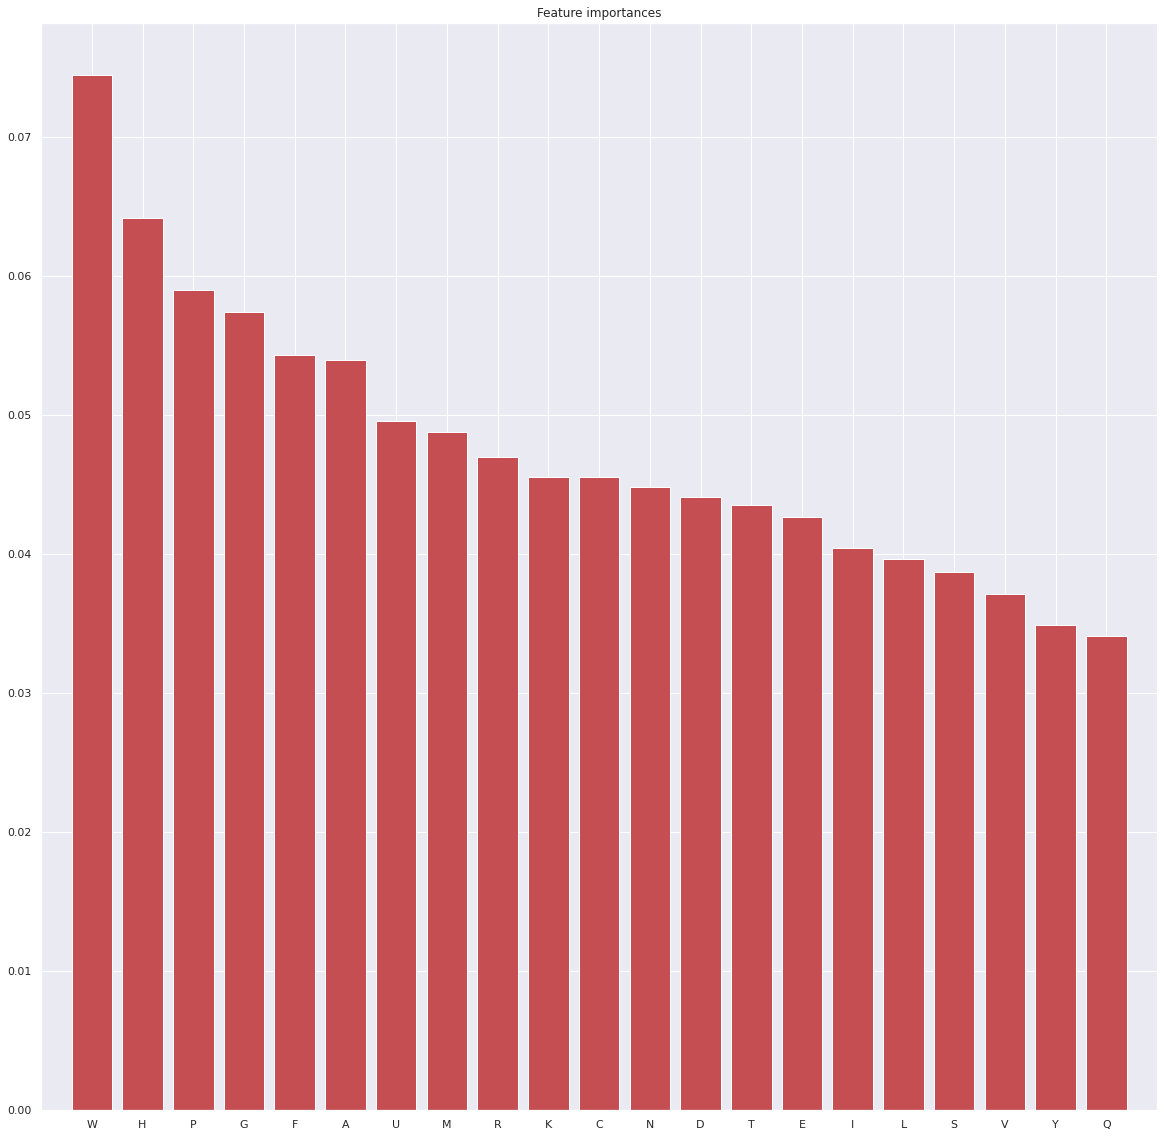

In [38]:
importances = rf.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

ordered_features = reorder(feature_list, indices, len(feature_list))

plt.figure()
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(train_features.shape[1]), ordered_features)
plt.xlim([-1, train_features.shape[1]])
plt.show()

In [39]:
# Prediction made with the model fitted above
predictions = rf.estimator_.predict(test_features)

The model accuracy is also reported. It answers to the question: how often is the classifier correct?

In [40]:
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(test_labels, predictions))

Accuracy: 0.5555555555555556


## Multinomial classification

Since in this data analysis it is necessary to classify more than two classes (in fact we have three diets), a multinomial classification was used. This allows also, in the future, to eventually expand the analysis by adding other diets.

In [46]:
# evaluate multinomial logistic regression model
import math
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# define dataset
X, y = features, labels
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial')
# fit the model on the whole dataset
model.fit(X, y)

LogisticRegression(multi_class='multinomial')

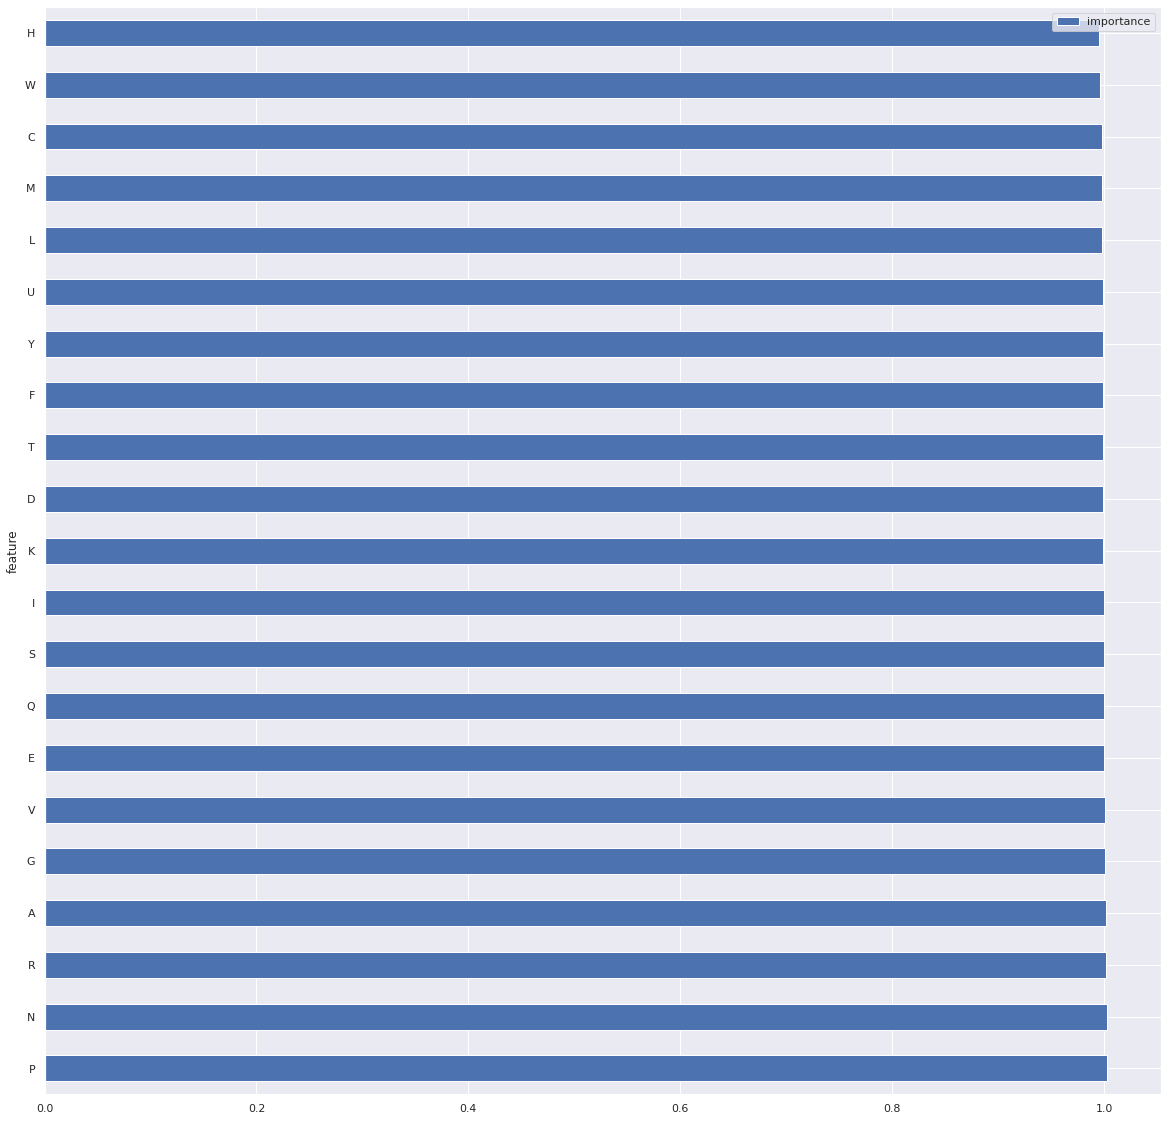

In [47]:
w = model.coef_[0]

feature_importance = pd.DataFrame(feature_list, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)

ax = feature_importance.plot.barh(x='feature', y='importance')
plt.show()

Logistic regression doesn't have a feature importance function. By means of the coefficients, it is possible to obtain a ranking of the features. But, as can be seen from the graph above, it is not very indicative in this case as the values of the features are very similar to each other. Although, we can see that, however little, the higher ranked features are part of the one extracted also from the Random Forest and, as can be seen below even from those pulled out with SelectFrommodel applied to multinomial LogisticRegression (which however appear in no particular order).

In [48]:
# define the multinomial logistic regression model
model_sel = SelectFromModel(LogisticRegression(multi_class='multinomial'))
# fit the model on the whole dataset
model_sel.fit(X, y)

SelectFromModel(estimator=LogisticRegression(multi_class='multinomial'))

In [49]:
# define the multinomial logistic regression model
model_sel = SelectFromModel(LogisticRegression(multi_class='multinomial'))
# fit the model on the whole dataset
model_sel.fit(X, y)

SelectFromModel(estimator=LogisticRegression(multi_class='multinomial'))

In [50]:
# Returns the number of selected features
selected_feat= train_features.columns[(model_sel.get_support())]
len(selected_feat)

9

In [51]:
# Prints the selected features not in order of importance
print(selected_feat)

Index(['A', 'C', 'H', 'L', 'M', 'N', 'P', 'R', 'W'], dtype='object')
